# iLINCS Numbers

Here the aim is to come up with preliminary numbers for the iLINCS project - 
to show how much data we have.

Structure:
* a) Load signature data
* b) Numbers for datasets
* c) Numbers for factors
* d) Numbers for conditions
* e) Number Conditions per Factor
* f) MeSH terms 

## a) Load signature data

In [22]:
"""iLINCS

The exercise here is to quantify HOW many diseases are there for which we have "disease" signatures

Structure:
    1. Imports, Variables, Functions
    2. Retrieve MeSH terms
    3. Retrieve Signature Datasets
    4. Maps MeSH terms to Signatures
    5. Plot Results
"""

# 1. Imports, Variables, FunctionsROOT
import matplotlib.cm as cm
import logging
from Bio import Entrez
import requests
import xml.etree.ElementTree as ET
import time

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables
Entrez.email = "dylandaltonsub@gmail.com"
base_url = "http://www.ilincs.org/api"
doi_data_path = "../data/DiseaseOntology/doid.obo"
mesh_file_path = "../data/MeSH/desc2023.xml"
d_dataset_2_mesh = dict()
d_signature_2_mesh = dict()
d_mesh_symbol_2_term = dict()
filter_criteria = lambda s: (s["factor"] == "disease.state") and (
    "normal" in s["level2"] or "control" in s["level2"] or "healthy" in s["level2"]
)


# functions
def fetch_disease_signatures(factor):
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def extract_disease_names_from_obo(file_path):
    """
    Extracts disease names from an OBO formatted file.

    Args:
    - file_path (str): Path to the OBO file.

    Returns:
    - List[str]: A list of disease names.
    """

    # Open and read the content of the OBO file
    with open(file_path, "r") as f:
        content = f.read()

    # The OBO format divides entries using '[Term]'. We split the content based on this to get individual entries.
    terms = content.split("[Term]")

    disease_names = []  # List to store extracted disease names

    # Iterate over each term/entry
    for term in terms:
        # Use a regular expression to search for the line that starts with 'name: '
        # This line contains the name of the disease.
        match = re.search(r"name: (.+)", term)

        # If a match is found (i.e., the term has a name), extract it and add to the list
        if match:
            disease_name = match.group(
                1
            )  # The actual name is captured in the first group of the regex
            disease_names.append(disease_name)

    return disease_names


def parse_mesh_data(file_path):
    """Parse MeSH XML data and extract disease terms."""
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract disease terms
    disease_terms = []
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        disease_terms.append(term)

    return disease_terms, None


def parse_mesh_data(file_path):
    """Parse MeSH XML data and extract disease terms.

    Retrieve the Botom-Most disease terms which contain the most specific
    information for a disease.

    Parameters:
        file_path: str()

    Return:
        disease_terms: list()
        list_tree_numbers: list()"""
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract disease terms
    disease_terms = list()
    list_tree_numbers = list()
    for descriptor in root.findall("DescriptorRecord"):
        # Check if the term is under the category of diseases
        tree_numbers = descriptor.findall("TreeNumberList/TreeNumber")
        for tree_number in tree_numbers:
            # This is a basic check for TreeNumbers starting with 'C' which usually denotes diseases in MeSH
            # You might need to adjust this based on the specific structure of your XML file
            if tree_number.text.startswith("C"):
                list_tree_numbers.append(tree_number.text)
                term = descriptor.find("DescriptorName/String").text
                disease_terms.append(term)
                break  # Break after adding the term to avoid duplicates

    return disease_terms, list_tree_numbers


def extract_pmid_from_publink(publink):
    """Extract the PubMed ID from the provided publink."""
    pmid_match = re.search(r"term=(\d+)\[UID\]", publink)
    if pmid_match:
        return pmid_match.group(1)
    return None


def get_pmid_from_geo_via_eutils(geo_id):
    # Use elink to establish links between GEO and PubMed databases
    handle = Entrez.elink(dbfrom="gds", db="pubmed", id=geo_id[3:])
    record = Entrez.read(handle)
    handle.close()

    # Extract the PMID from the linked records
    # if it has LinkSetDb report else return None
    if len(record[0]["LinkSetDb"]) > 0:
        return record[0]["LinkSetDb"][0]


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_mesh_terms_from_pubmed(pmid):
    """Fetch MeSH terms for a given PubMed ID."""
    if not pmid:
        return []

    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {"db": "pubmed", "id": pmid, "retmode": "xml"}
    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print(f"Error fetching MeSH terms for PMID {pmid}: {response.text}")
        return []

    # Parse the XML response to extract MeSH terms
    root = ET.fromstring(response.text)
    mesh_terms = [
        descriptor.findtext("DescriptorName")
        for descriptor in root.findall(".//MeshHeading")
    ]

    # Parse the XML response to extract MeSH tree numbers
    mesh_tree_numbers = list()
    for descriptor in root.findall(".//MeshHeading"):
        # Find the DescriptorName element and get its UI attribute
        descriptor_ui = descriptor.find("DescriptorName").get("UI")
        # Use the UI to find the corresponding TreeNumberList/TreeNumber elements
        tree_numbers = root.findall(
            f".//DescriptorRecord[DescriptorUI='{descriptor_ui}']/TreeNumberList/TreeNumber"
        )
        mesh_tree_numbers.extend([tree_number.text for tree_number in tree_numbers])

    return mesh_terms, mesh_tree_numbers


def extract_pmid_from_publink(publink):
    """Extract the PubMed ID from the provided publink."""
    pmid_match = re.search(r"term=(\d+)\[UID\]", publink)
    if pmid_match:
        return pmid_match.group(1)
    return None


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Retrieve MeSH terms
# retrieve disease terms and store in dictionary
disease_names_mesh, symbol_mesh = parse_mesh_data(file_path=mesh_file_path)
d_mesh_symbol_2_term = dict(zip(symbol_mesh, disease_names_mesh))

# 3. Retrieve Signature Datasets
start_time = time.time()
logging.info("Starting to Get All Signatures: ")

# get all signatures
signatures = fetch_disease_signatures()

end_time = time.time()
logging.info(
    f"Finished Getting All Signatures. Total time taken: %.4f seconds"
    % (end_time - start_time)
)

2024-01-26 14:52:05,559 - INFO - Starting to Get All Signatures: 
2024-01-26 14:52:28,023 - INFO - Finished Getting All Signatures. Total time taken: 22.4634 seconds


## b) Numbers for datasets

In [24]:
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

In [25]:
# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# filter Data
data_plot = Counter([s["datasetid"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Datasets: {len(set(data_plot))}")

Nº of Unique Datasets: 1087


/tmp/ipykernel_27638/630490298.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Blues")


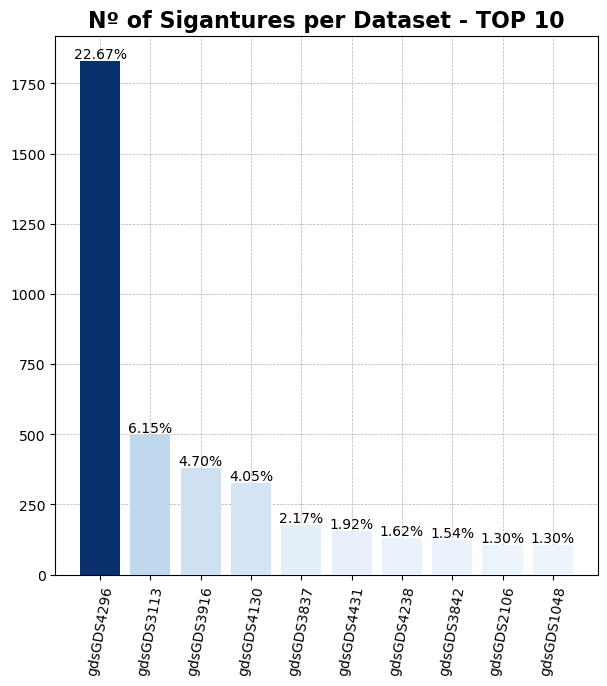

In [26]:
# get data for plot
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))

# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap("Blues")

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)

plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Dataset - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_datasets.png", dpi=300, bbox_inches="tight"
)

## c) Numbers for factors


In [27]:
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot = Counter([s["factor"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Factors: {len(set(data_plot))}")

Nº of Unique Factors: 22


/tmp/ipykernel_27638/1982852845.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


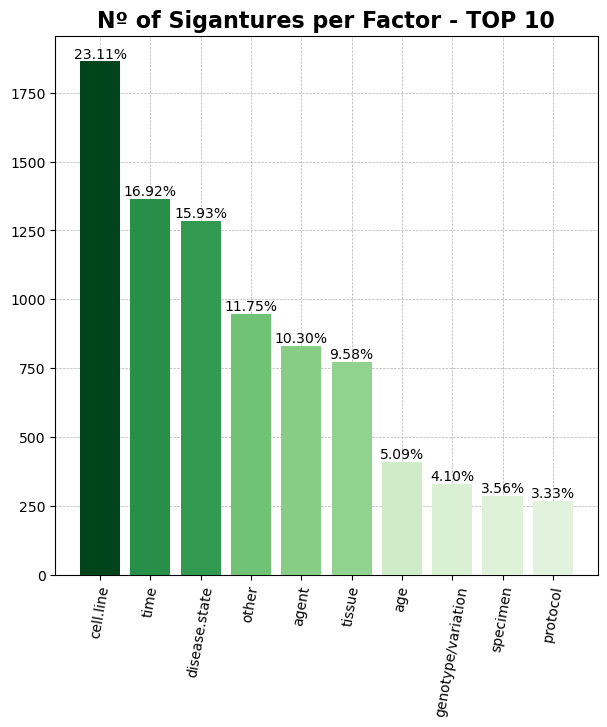

In [28]:
# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Greens"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Factor - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_factors.png", dpi=300, bbox_inches="tight"
)

## d) Numbers for conditions

In [29]:
from collections import Counter
import matplotlib.cm as cm


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot_ = [s["level1"] for s in signatures if s["libraryid"] == "LIB_1"]
data_plot_.extend([s["level2"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Conditions: {len(set(data_plot))}")

Nº of Unique Conditions: 22


/tmp/ipykernel_27638/1541039538.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


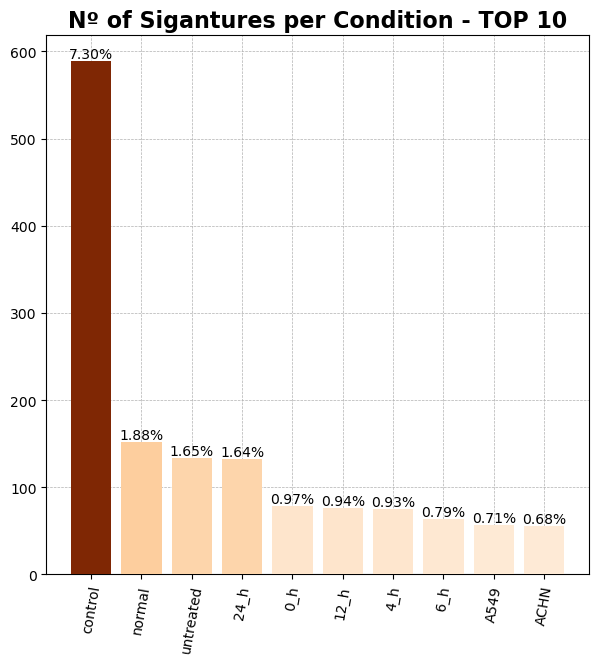

In [30]:
data_plot = Counter(data_plot_)

# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Oranges"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Condition - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_conditions.png", dpi=300, bbox_inches="tight"
)

## e) Nº Conditions per Factor

In [31]:
from collections import Counter
import matplotlib.cm as cm


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot_ = [
    s["level1"]
    for s in signatures
    if (s["libraryid"] == "LIB_1") and (s["factor"] == "cell.line")
]
data_plot_.extend(
    [
        s["level2"]
        for s in signatures
        if s["libraryid"] == "LIB_1" and (s["factor"] == "cell.line")
    ]
)

print(f"Nº of Unique Conditions: {len(set(data_plot))}")

Nº of Unique Conditions: 3080


/tmp/ipykernel_27638/2325226783.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


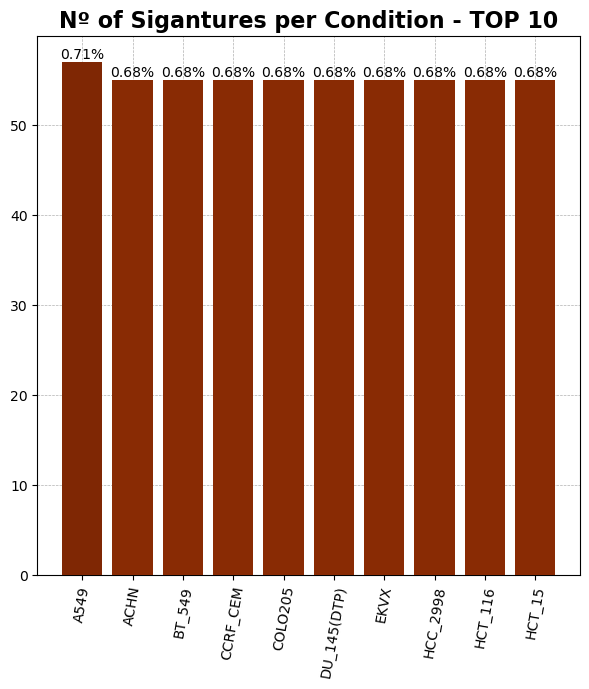

In [32]:
data_plot = Counter(data_plot_)

# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Oranges"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Condition - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
# plt.savefig(
#     "../results/figures/iLINCS/numbers/n_conditions.png", dpi=300, bbox_inches="tight"
# )

In [33]:
import requests
import json


def query_cellosaurus(cell_line):
    # Cellosaurus API endpoint for querying a specific cell line
    url = f"https://web.expasy.org/cgi-bin/cellosaurus/api/cell-line/{cell_line}?format=json"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Extracting disease information, assuming it's under a key like 'disease' or similar
        # The exact key name should be checked in the API response or documentation
        disease = data.get("disease", {}).get(
            "name", "Disease information not available"
        )
        return disease
    else:
        return f"Error querying Cellosaurus: {response.status_code}"


# Example usage
cell_line_disease = query_cellosaurus("A549")
print(cell_line_disease)

Error querying Cellosaurus: 404


## f) MeSH terms

### f.1) MeSH terms for each dataset

In [34]:
""" MeSH Terms for each dataset

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Retrieve MeSH symbols
"""

# 1. Imports, Variables, Functions
# imports
import requests
import xml.etree.ElementTree as ET
import time, re
from Bio import Entrez
import logging
import pandas as pd
import json

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
base_url = "http://www.ilincs.org/api"


# functions
def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Load Data
# load datasets
datasets = get_disease_datasets()

# load MeSH terms from datasets
# generated in SQL notebook
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

# load mesh terms
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

/tmp/ipykernel_27638/2988766309.py:43: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(path_data)
2024-01-26 14:52:30,653 - INFO - Data loaded successfully.


In [35]:
# 3. Retrieve MeSH symbols
# we can retrieve from pmid the mesh terms but we need to map these to symbols
failed_translation_all = list()
d_dataset_2_mesh = dict()

for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbol[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbol"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms

In [36]:
len([k for k, v in d_dataset_2_mesh.items() for s in v["symbol"]])

31898

In [37]:
keys = list()
for k in d_dataset_2_mesh.keys():
    for s in d_dataset_2_mesh[k]["symbol"]:
        if s.startswith("C"):
            keys.append(k)
            break
print(len(keys))

748


#### f.1.1) MeSH terms for each dataset - root terms

In [38]:
# Get ROOT terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms
level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]

        terms_specific_level = list(
            set([t[:level_split] for t in terms if filter_criteria(t)])
        )
        all_symbols.extend(terms_specific_level)


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]

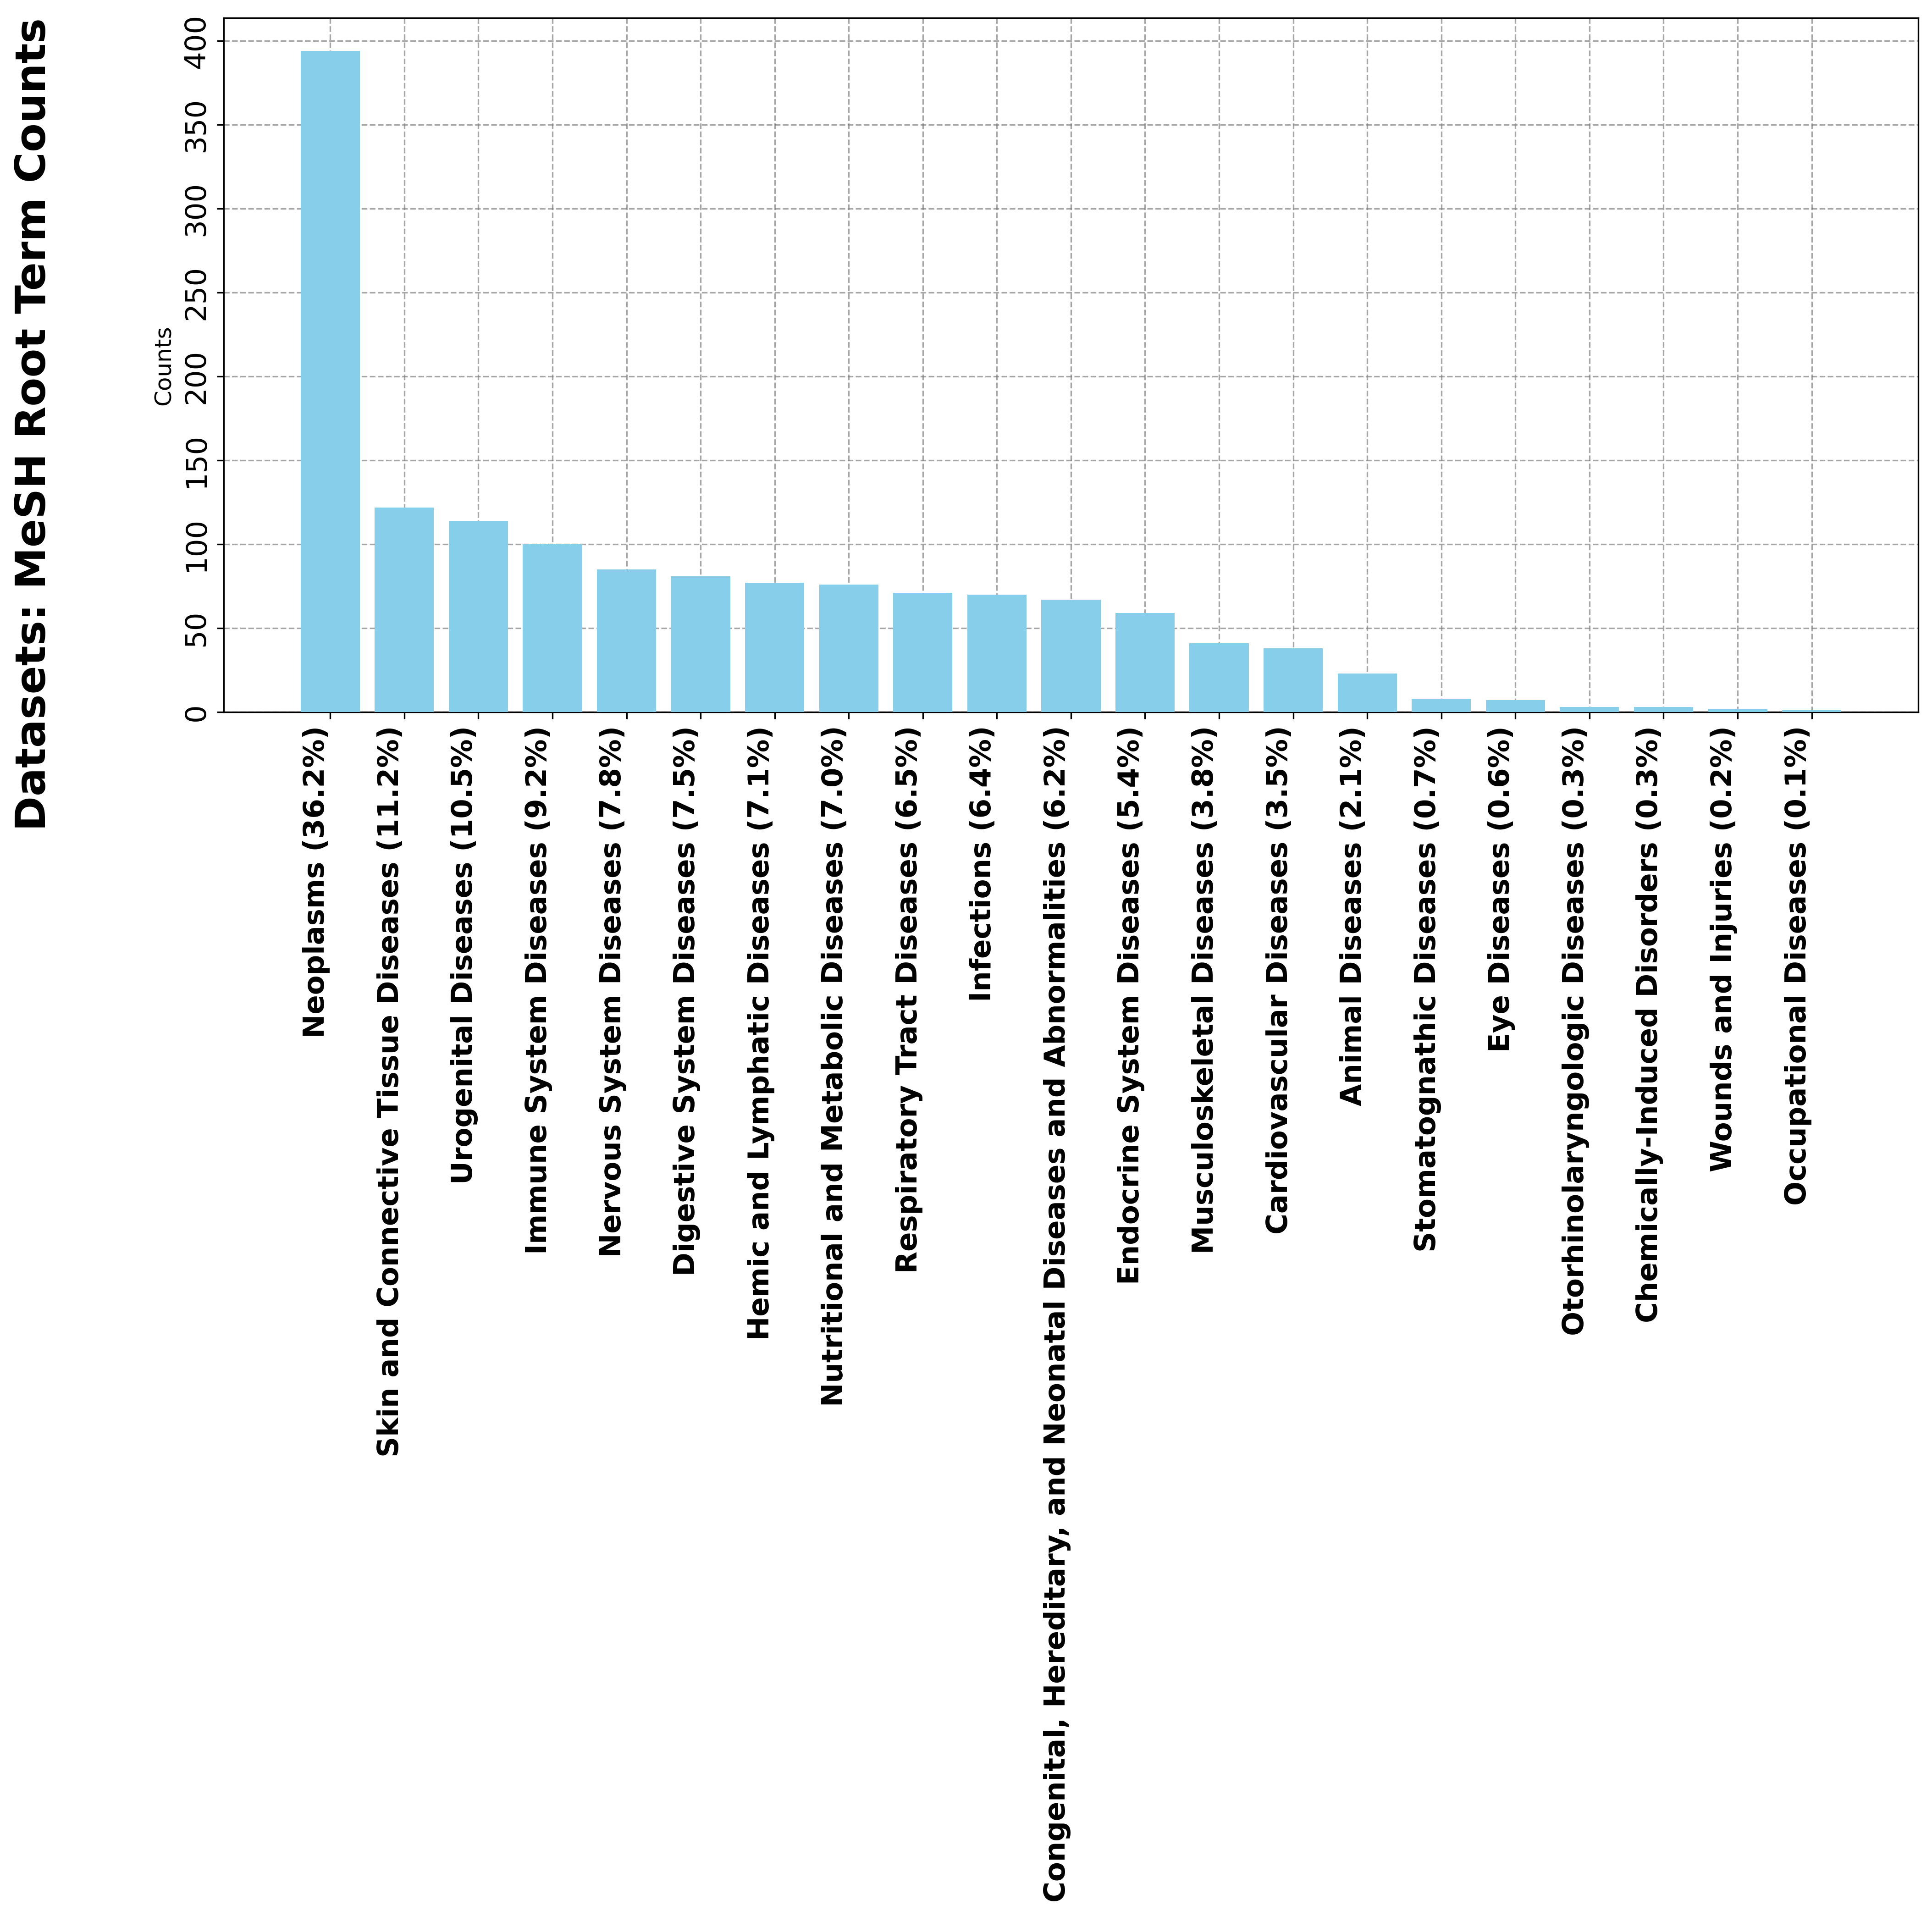

In [39]:
import matplotlib.pyplot as plt
from collections import Counter


# Count the occurrences of each category
category_counts = Counter(all_terms)


# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/1087*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc, values, color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    "Datasets: MeSH Root Term Counts",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.datasets.root.png",
    dpi=300,
    bbox_inches="tight",
)

#### f.1.2) MeSH terms for each dataset - specific terms

In [40]:
# Get SPECIFIC terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms

level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


def find_longest_string(lst):
    """Find Longets String in a list
    Parameters:
        lst: list()
    Return:
        longest: str()
    """
    longest = ""
    for item in lst:
        if len(item) > len(longest):
            longest = item
    # alternative
    # longest = max(lst, key=len)
    return longest


# root terms
root_terms = set([s[:3] for s in mesh_symbol_2_term.keys() if filter_criteria(s)])
all_symbols = list()

for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]
        # iterate through different root terms
        for root_term in root_terms:
            terms_for_root = [t for t in terms if t.startswith(root_term)]
            if len(terms) > 0:
                longest_length_term = find_longest_string(terms_for_root)
                all_symbols.extend(
                    [t for t in terms_for_root if len(t) == len(longest_length_term)]
                )


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]

# count method 2
all_symbols_2 = list()
for symbol in all_symbols:
    all_symbols_2.extend([symbol for k, v in d_dataset_2_mesh.items() if symbol in v])

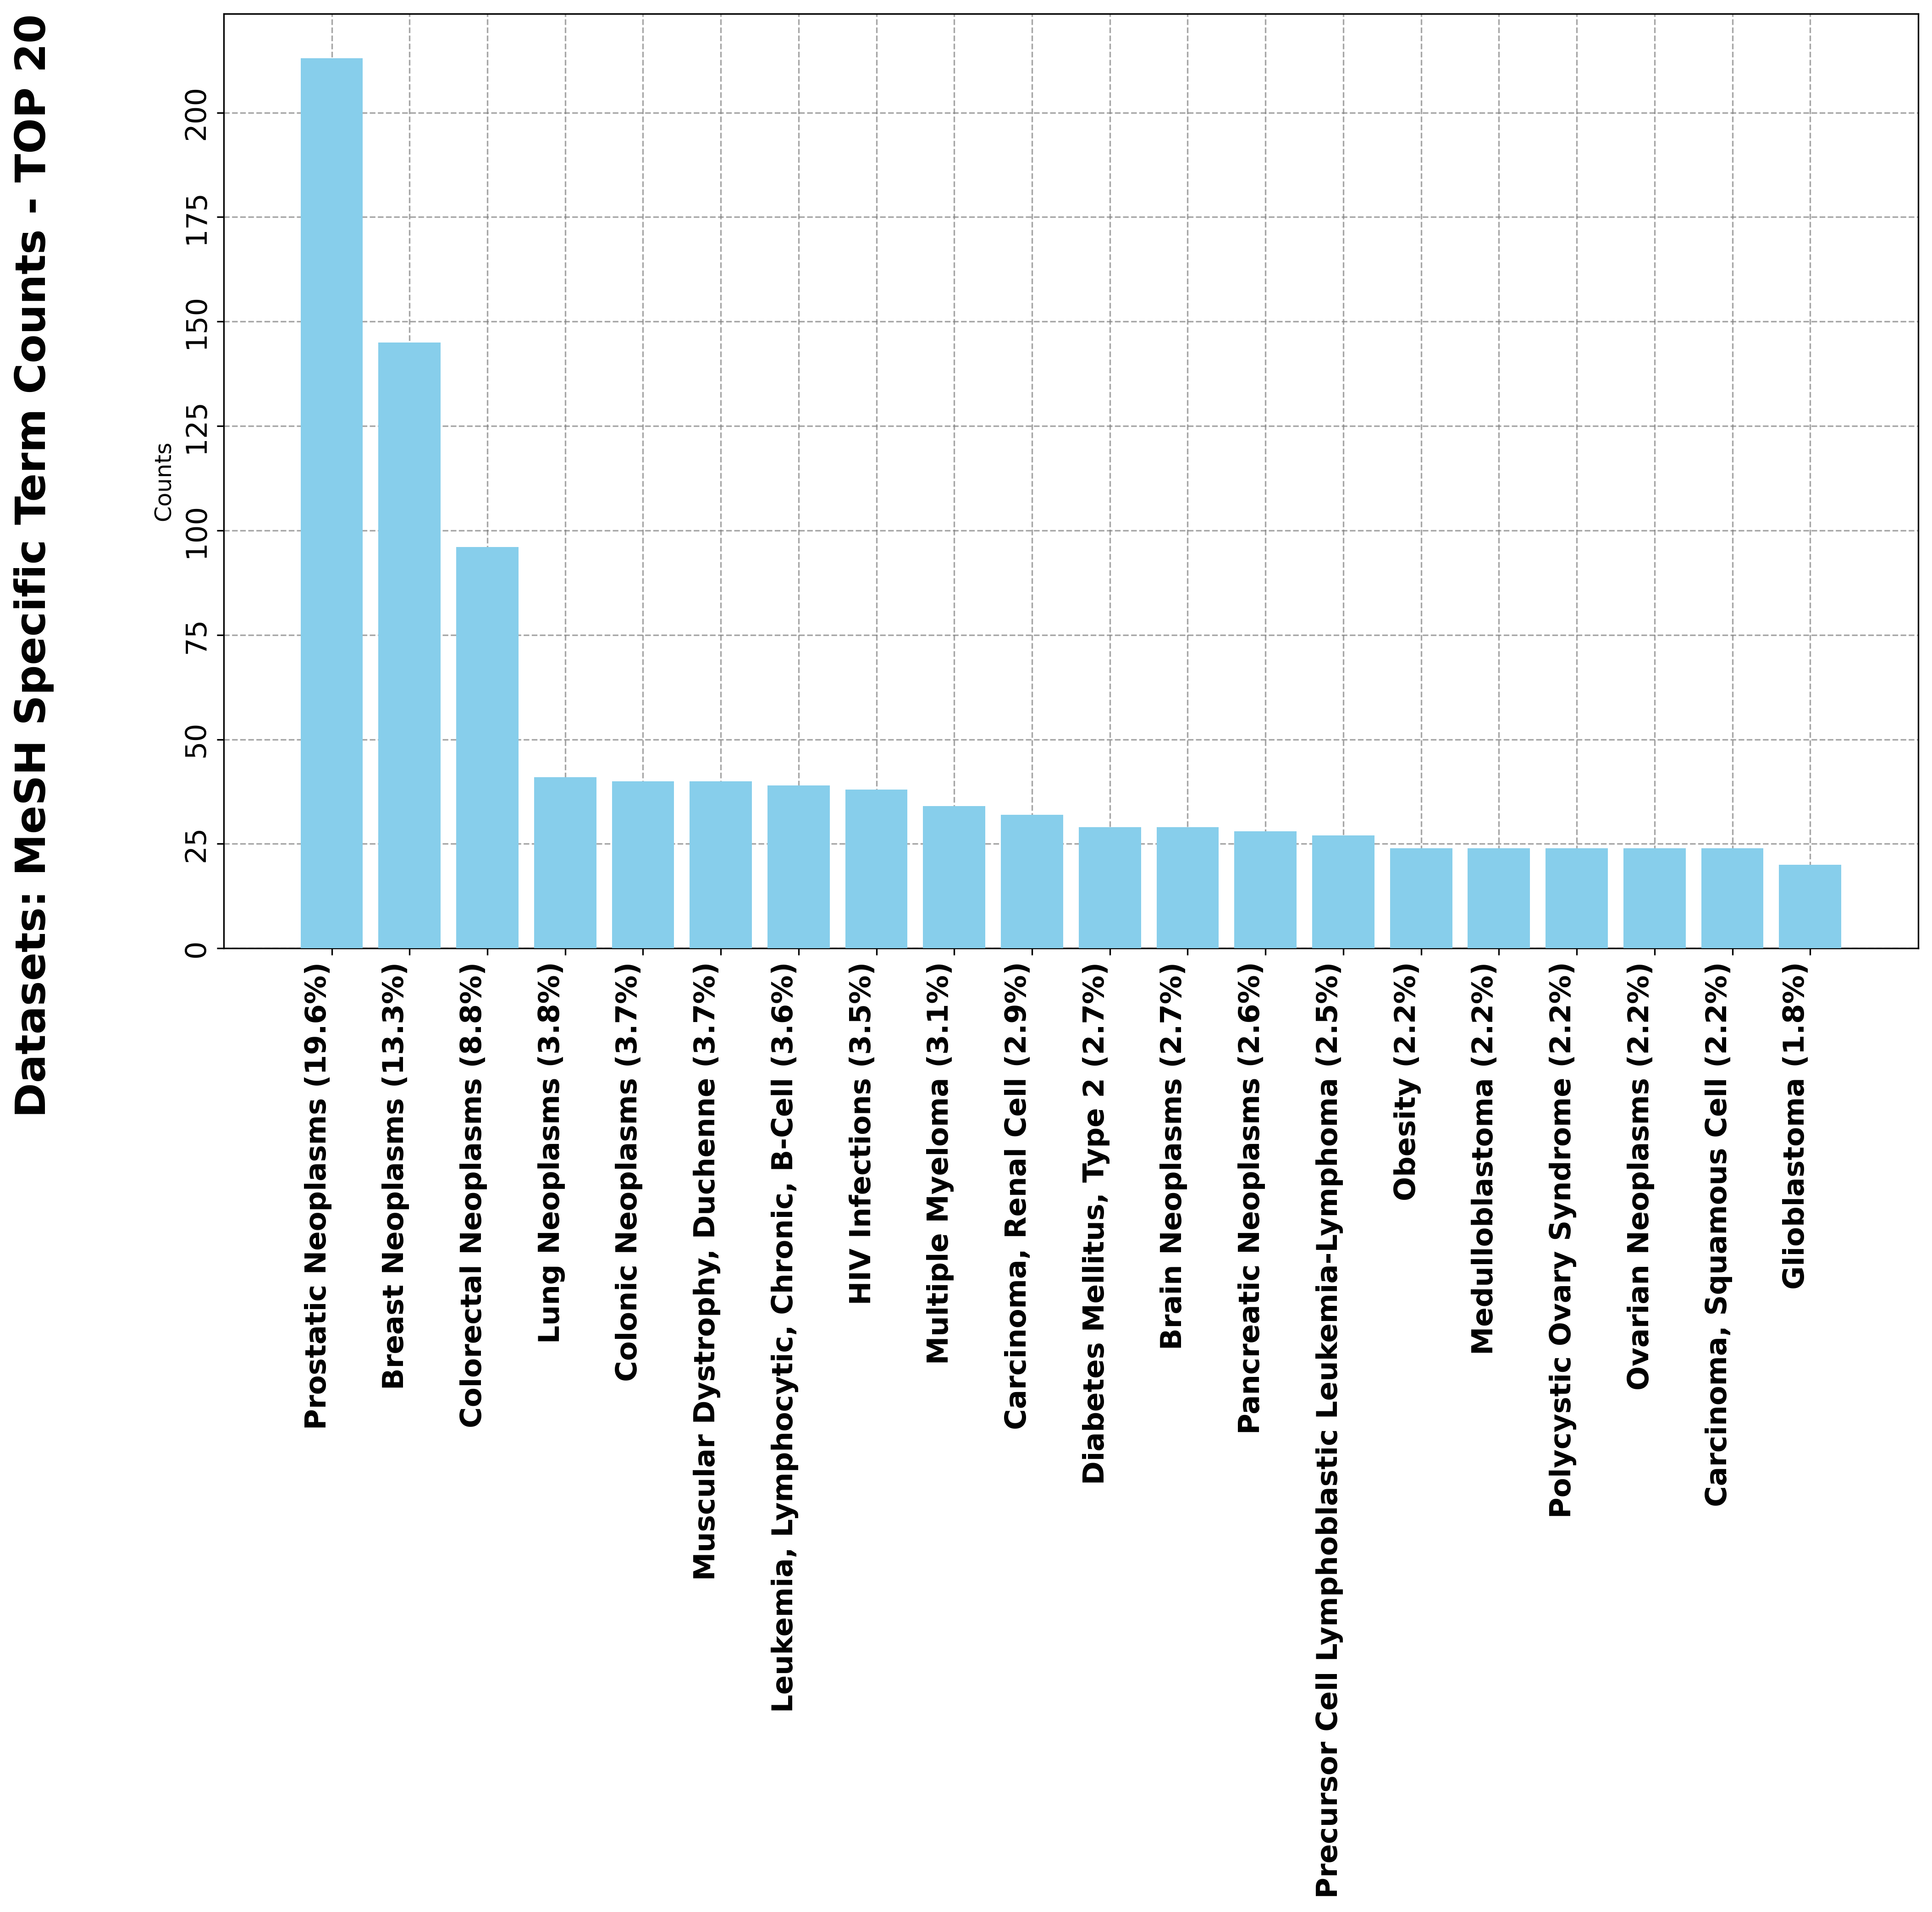

In [41]:
import matplotlib.pyplot as plt
from collections import Counter

# TOP N
top_n = 20

# Count the occurrences of each category
category_counts = Counter(all_terms)

# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/1087*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc[:top_n], values[:top_n], color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    f"Datasets: MeSH Specific Term Counts - TOP {top_n}",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.datasets.specific.png",
    dpi=300,
    bbox_inches="tight",
)

### f.2) MeSH terms for each signature

In [42]:
""" MeSH Terms for each dataset

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Retrieve MeSH symbols
"""

# 1. Imports, Variables, Functions
# imports
import requests
import xml.etree.ElementTree as ET
import time, re
from Bio import Entrez
import logging
import pandas as pd
import json

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
base_url = "http://www.ilincs.org/api"
mesh_file_path = "../data/MeSH/desc2023.xml"


# functions
def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


def get_disease_datasets_all():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        # filter disease signatures
        df_data = df_data[filter_df]
    except Exception as e:
        print(f"An error occured {e}")
        return []

    return df_data["datasetid"].to_list()


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Load Data
# load datasets
datasets = get_disease_datasets_all()

# load MeSH terms from datasets
# generated in SQL notebook
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

# load mesh terms
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

/tmp/ipykernel_27638/2747954764.py:72: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(path_data)


In [43]:
# 3. Retrieve MeSH symbols
# we can retrieve from pmid the mesh terms but we need to map these to symbols
failed_translation_all = list()
d_dataset_2_mesh = dict()

for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbol[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbol"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms

#### f.2.1) MeSH terms for each signature - root terms

In [44]:
# Get ROOT terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms
level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


for k in datasets:
    if k in d_dataset_2_mesh.keys() and d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]

        terms_specific_level = list(
            set([t[:level_split] for t in terms if filter_criteria(t)])
        )
        all_symbols.extend(terms_specific_level)


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]


all_symbols_2 = list()
filter_datasets = (
    lambda d: d in d_dataset_2_mesh.keys() and d_dataset_2_mesh[d]["symbol"] is not None
)
datasets_clean = [d for d in datasets if filter_datasets(d)]
for symbol in set(all_symbols):
    all_symbols_2.extend(
        [symbol for k in datasets_clean if (term in d_dataset_2_mesh[k]["symbol"])]
    )
all_terms_2 = [mesh_symbol_2_term[s] for s in all_symbols]

NameError: name 'term' is not defined

In [ ]:
print(f"nº all_terms {len(all_terms)} nº all_terms_2 {len(all_terms_2)}")

nº all_terms 7820 nº all_terms_2 7820


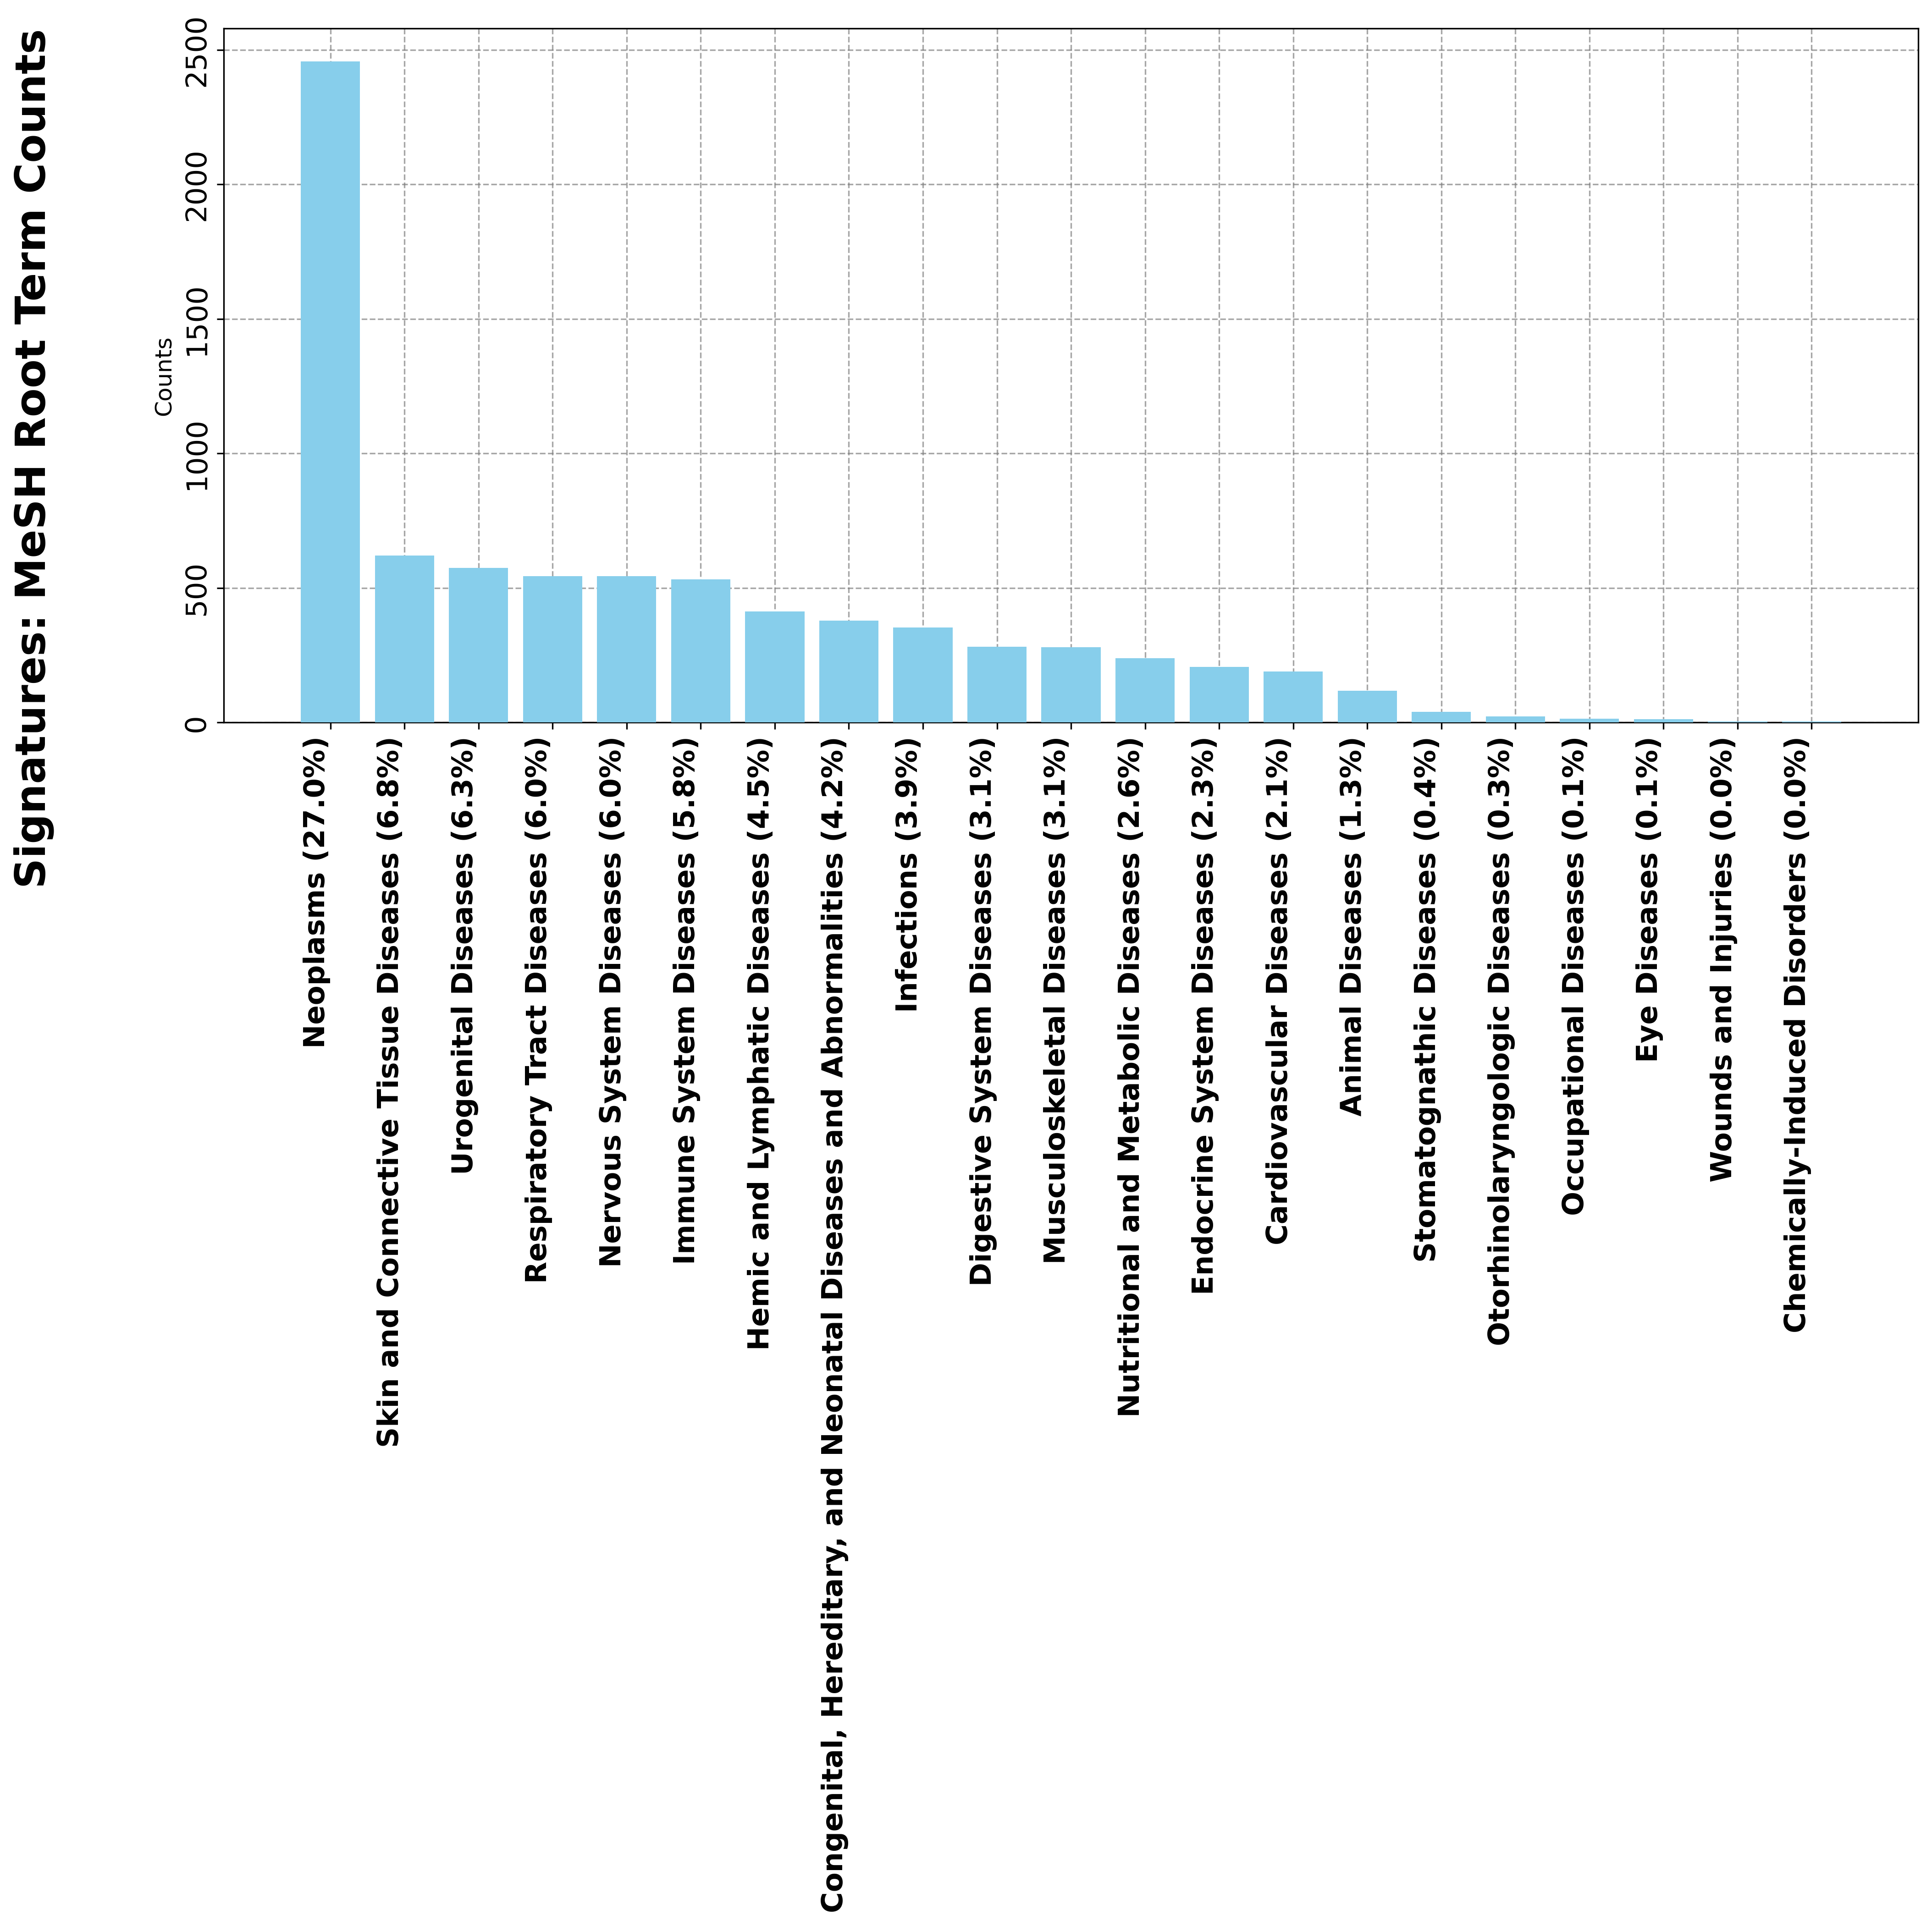

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter


# Count the occurrences of each category
category_counts = Counter(all_terms)


# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/9097*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc, values, color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    "Signatures: MeSH Root Term Counts",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.signatures.root.png",
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
df = pd.DataFrame({"Specific MeSH Terms": labels, "Nº Signatures": values})
df.to_csv("../results/tmp/root_mesh_terms.csv", index=False)

#### f.2.2) MeSH terms for each signature - specific terms

In [ ]:
# Get SPECIFIC terms ! ! !
# exclude terms that are not diseases
# exclude C23: Pathological Conditions, Signs and Symptoms

all_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


def find_longest_string(lst):
    """Find Longets String in a list
    Parameters:
        lst: list()
    Return:
        longest: str()
    """
    longest = ""
    for item in lst:
        if len(item) > len(longest):
            longest = item
    # alternative
    # longest = max(lst, key=len)
    return longest


# root terms
root_terms = set([s[:3] for s in mesh_symbol_2_term.keys() if filter_criteria(s)])
all_symbols = list()
all_datasets = list()

for k in datasets:
    symbols_dataset = list()
    if k in d_dataset_2_mesh.keys() and d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]
        # iterate through different root terms
        for root_term in root_terms:
            terms_for_root = [t for t in terms if t.startswith(root_term)]
            if len(terms_for_root) > 0:
                longest_length_term = find_longest_string(terms_for_root)
                if len(longest_length_term) > 5:  # exclude root terms ! ! !
                    symbols_dataset.extend(
                        [
                            t
                            for t in terms_for_root
                            if len(t) == len(longest_length_term)
                        ]
                    )

            if len(symbols_dataset) > 0:  # if results found add to all symbols
                all_symbols.extend(symbols_dataset)
                all_datasets.append(k)

                if "C04" in symbols_dataset:  # a check ! ! !
                    print("ERR")
                    print(f"terms = {terms}")
                    print(f"root_term  = {root_term}")
                    print(f"symbols_dataset = {symbols_dataset}")
                    print(f"longest_length_term = {longest_length_term}")
                    print(f"terms_for_root = {terms_for_root}")
                    break


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]

# Here we have 3 problems
# Problem 1: 2 different symbols might have same term  - overestimation problem
# Problem 2: signatures might have more specific term annotated and not
# therefore be seen when counting a more general term

all_terms_2 = list()
filter_datasets = (
    lambda d: d in d_dataset_2_mesh.keys() and d_dataset_2_mesh[d]["symbol"] is not None
)
datasets_clean = [d for d in datasets if filter_datasets(d)]
for term in set(all_terms):
    symbols = mesh_term_2_symbol[term]
    for dataset in datasets_clean:  # loop ONCE through ALL datasets
        # each dataset appears the nº of times
        # there are signatures for said dataset
        # i.e if a dataset has 10 signaturs it
        # appears 10 times
        for symbol in symbols:  # loop through possible term symbols
            for dataset_symbol in d_dataset_2_mesh[dataset]["symbol"]:
                if symbol in dataset_symbol:
                    all_terms_2.append(term)
                    # IF IT FINDS ONE instance where this is true
                    # break loop ! ! ! Avoid over-estimating terms! ! !
                    break

In [ ]:
longest_length_term = "C15.378.553.546"
terms_for_root = [
    "C12.100.937.640.700",
    "C16.320",
    "C01.150.252.410.040.552",
    "C04",
    "C15.378.553.546",
    "C15.378.190.625",
]
[t for t in terms_for_root if len(t) == len(longest_length_term)]

['C15.378.553.546', 'C15.378.190.625']

In [ ]:
[s for s in all_symbols if len(s) < 5]

['C04', 'C04']

In [ ]:
print(f"nº of all_terms {len(all_terms)} nº of all_terms_2 {len(all_terms_2)}")

nº of all_terms 178402 nº of all_terms_2 26021


In [ ]:
list_1 = list()
for s in set(all_symbols):
    t = mesh_symbol_2_term[s]
    if t in list_1:
        print(t)
        break

    else:
        list_1.append(t)

TDP-43 Proteinopathies


In [ ]:
mesh_term_2_symbol["Neoplasms"]

['C04']

In [ ]:
list(set(all_symbols))[1]

'C18.452.845.800'

In [ ]:
mesh_symbol_2_term["C10.574.950"]

'TDP-43 Proteinopathies'

In [ ]:
len(all_terms_2)

6458

In [ ]:
success = list()
for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        if any([t.startswith("C") for t in d_dataset_2_mesh[k]["symbol"]]):
            success.append(k)

print(len(success))

748


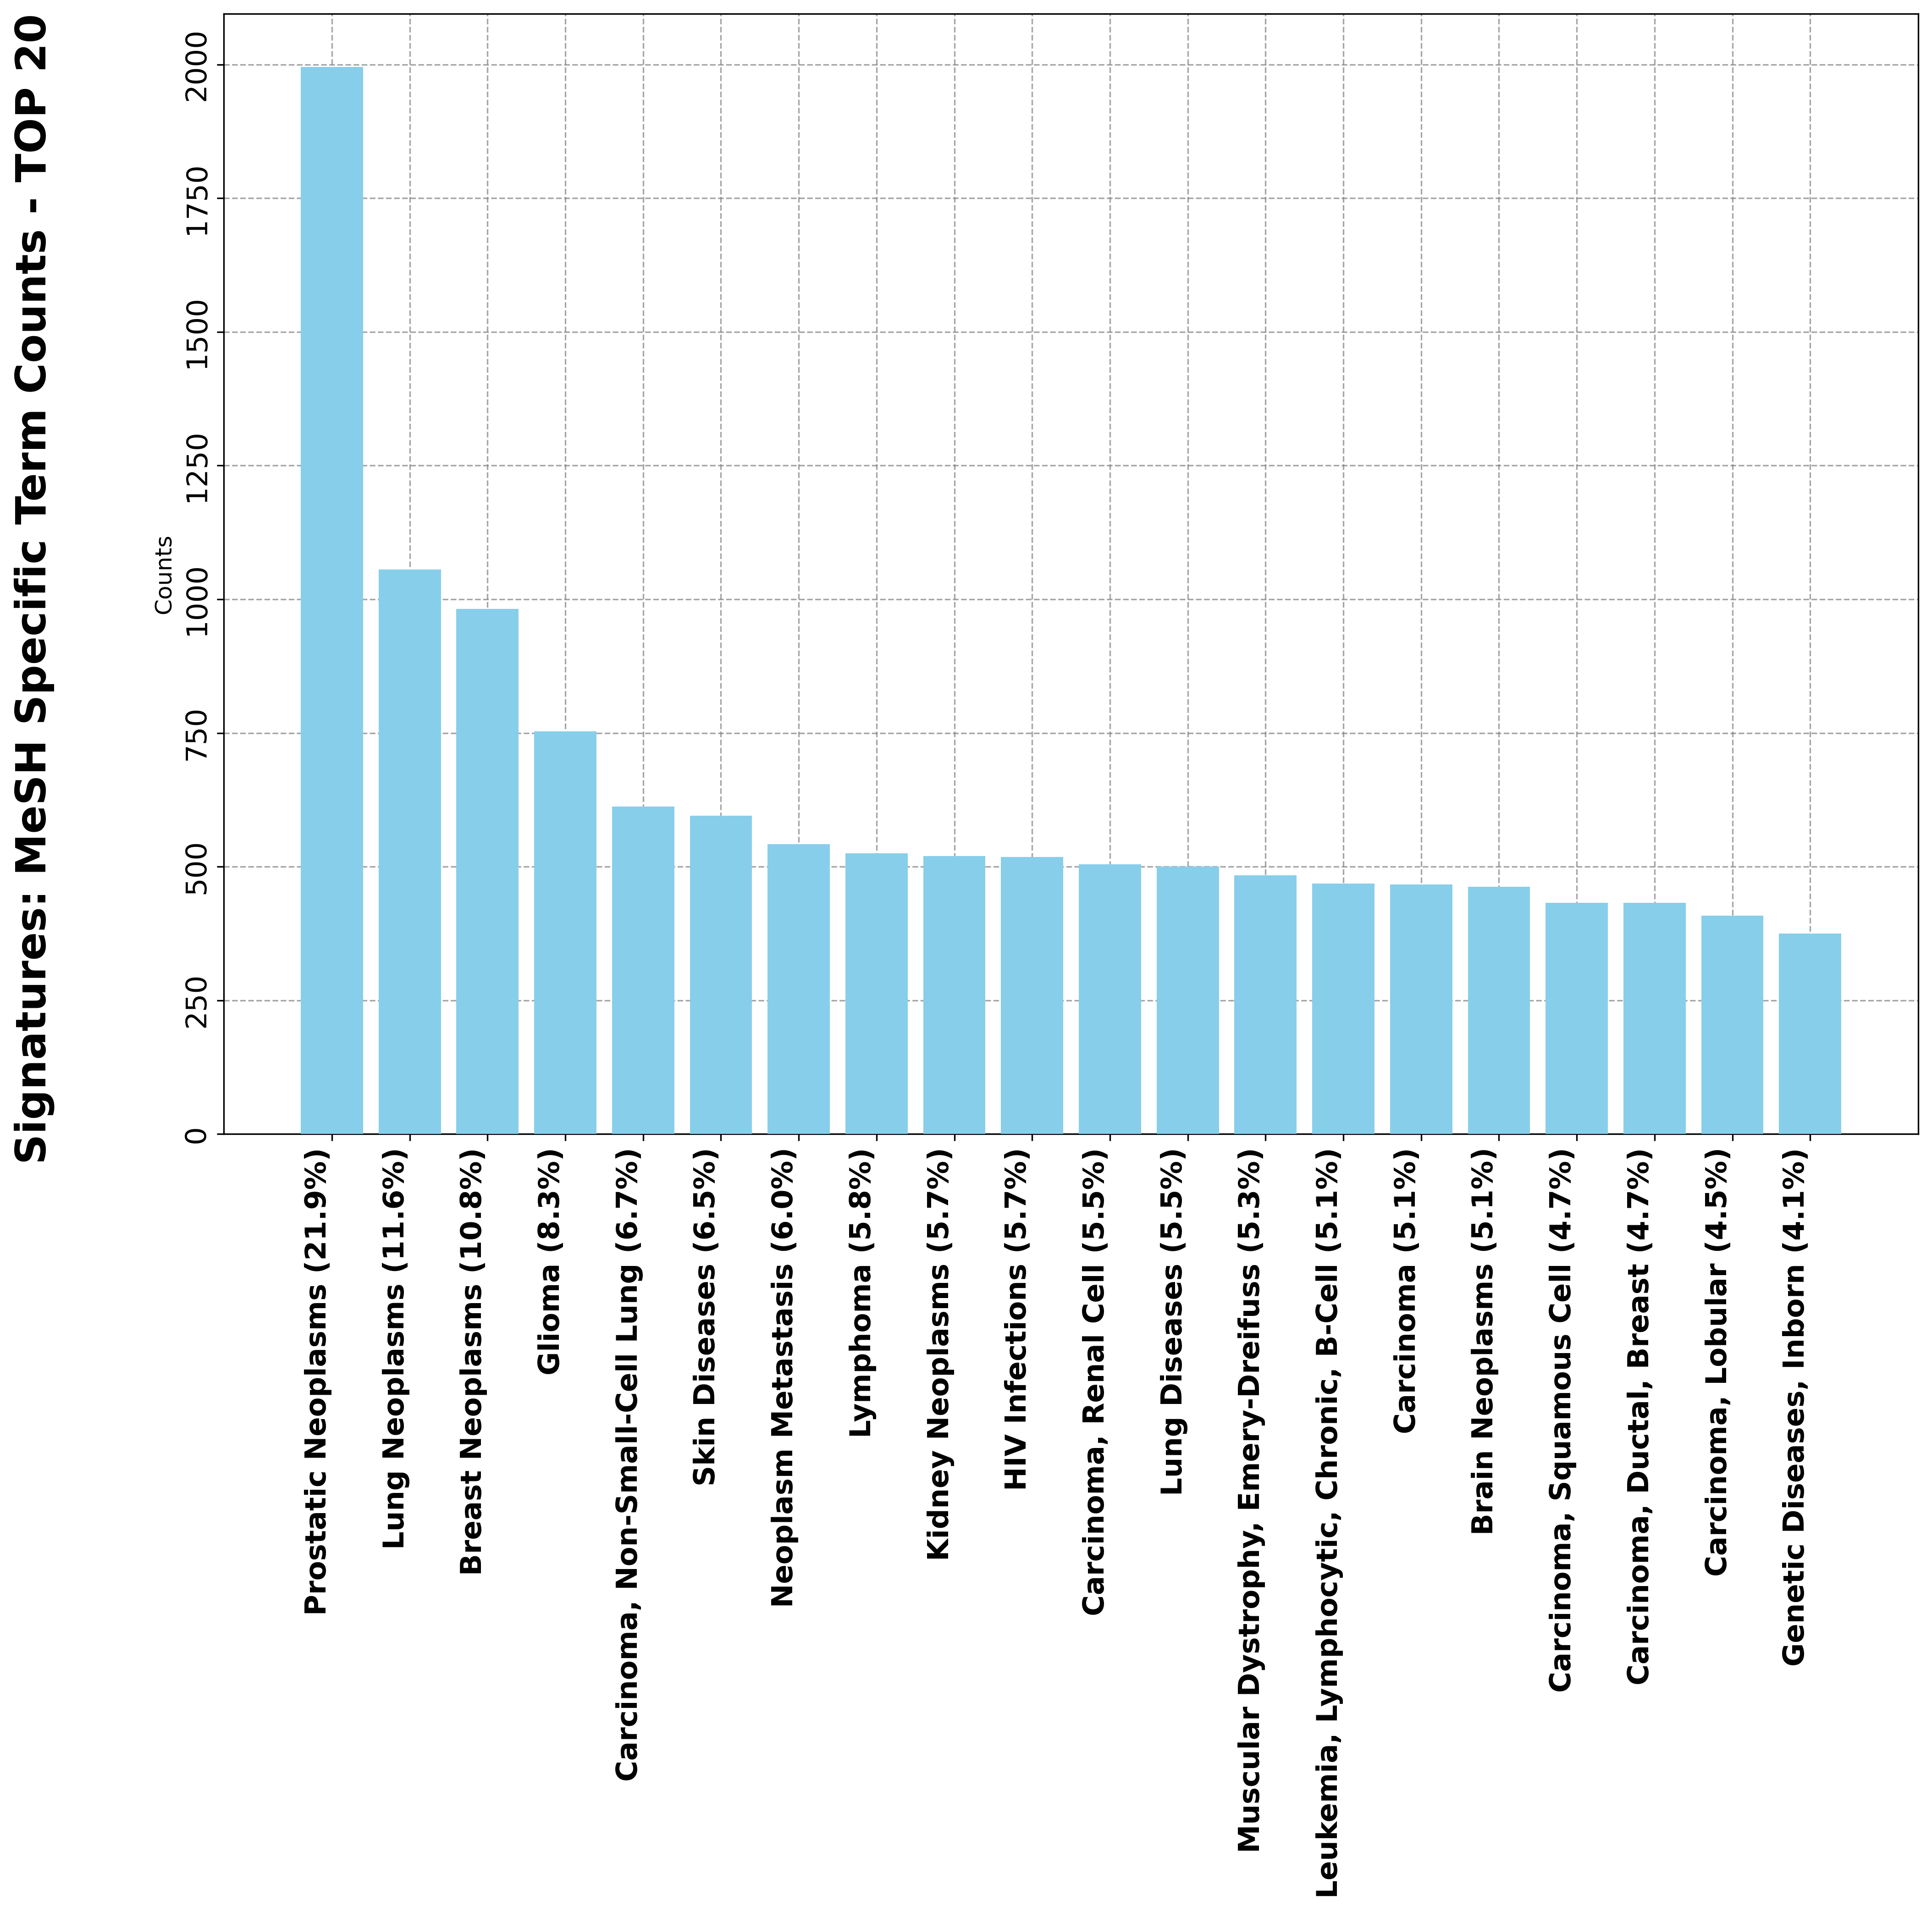

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# TOP N
top_n = 20

# Count the occurrences of each category
category_counts = Counter(all_terms_2)

# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)
labels_perc = [f"{l} ({v/9097*100:.1f}%)" for l, v in zip(labels, values)]

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels_perc[:top_n], values[:top_n], color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    f"Signatures: MeSH Specific Term Counts - TOP {top_n}",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.savefig(
    "../results/figures/iLINCS/numbers/n_mesh.sigantures.specific.png",
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
mesh_term_2_symbol["Prostatic Neoplasms"]

['C04.588.945.440.770',
 'C12.100.500.260.750',
 'C12.100.500.565.625',
 'C12.200.294.260.750',
 'C12.200.294.565.625',
 'C12.200.758.409.750',
 'C12.900.619.750']

In [ ]:
mesh_symbol_2_term["C12"]

'Urogenital Diseases'

In [ ]:
df = pd.DataFrame({"Specific MeSH Terms": labels, "Nº Signatures": values})
df.to_csv("../results/tmp/specific_mesh_terms.csv", index=False)

## DataFrame with MeSH terms

In [45]:
""" DataFrame with MeSH terms

Here we will generate a DataFrame which will have as rows MeSH terms and as columns
Nº of signatures, Nº of datasets, Nº of which have baseline normal/healthy/control condition,
Nº of which Factor is: cell line, disease state, time, agent, age, genotype/variation, specimen, 
protocol

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Create DataFrame
    4. Save DataFrame

"""

# 1. Imports, Variables, FunctionsROOT
import matplotlib.cm as cm
import logging
from Bio import Entrez
import requests
import xml.etree.ElementTree as ET
import time, json
import pandas as pd

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables
Entrez.email = "dylandaltonsub@gmail.com"
base_url = "http://www.ilincs.org/api"
doi_data_path = "../data/DiseaseOntology/doid.obo"
mesh_file_path = "../data/MeSH/desc2023.xml"
d_dataset_2_mesh = dict()
d_signature_2_mesh = dict()
d_mesh_symbol_2_term = dict()
filter_criteria = lambda s: (s["factor"] == "disease.state") and (
    "normal" in s["level2"] or "control" in s["level2"] or "healthy" in s["level2"]
)


# functions
def fetch_disease_signatures():
    """Fetch Disease Signatures"""
    endpoint = f"{base_url}/SignatureMeta"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbols = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbols[term] = tree_numbers

    return mesh_term_2_symbols, mesh_symbol_2_term


def find_longest_string(lst):
    """Find Longets String in a list
    Parameters:
        lst: list()
    Return:
        longest: str()
    """
    longest = ""
    for item in lst:
        if len(item) > len(longest):
            longest = item
    # alternative
    # longest = max(lst, key=len)
    return longest


# 2. Load Data
# load signatures
signatures = fetch_disease_signatures()

# load MeSH terms from datasets
# generated in SQL notebook
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

# load mesh terms
mesh_term_2_symbols, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

In [46]:
# Dataset 2 MeSH dictionary
# {"dataset_id":{"symbols":[],"terms":[]}}
# IMPORTANT: there may be more symbols than terms
# we can retrieve from pmid the mesh terms but we need to map these to symbols
failed_translation_all = list()

for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbols[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbols"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms

logging.info(f"Failed translation of {len(failed_translation_all)} MeSH terms.")

2024-01-26 14:55:08,579 - INFO - Failed translation of 12 MeSH terms.


In [47]:
# dictionary signature to mesh
# {"signatureid": {"datasetid": [], "signature" : {} , "terms": [], "symbols": []}}
for signature in [
    s for s in signatures if s["libraryid"] == "LIB_1"
]:  # disease signatures
    datasets_no_mesh = list()
    signature_id = signature["signatureid"]
    dataset_id = signature["datasetid"]
    d_signature_2_mesh[signature_id] = dict()
    d_signature_2_mesh[signature_id]["datasetid"] = dataset_id
    d_signature_2_mesh[signature_id]["signature"] = signature

    if dataset_id not in d_dataset_2_mesh.keys():
        d_signature_2_mesh[signature_id]["terms"] = []
        d_signature_2_mesh[signature_id]["symbols"] = []

    else:
        d_signature_2_mesh[signature_id]["terms"] = d_dataset_2_mesh[dataset_id][
            "terms"
        ]
        d_signature_2_mesh[signature_id]["symbols"] = d_dataset_2_mesh[dataset_id][
            "symbols"
        ]

logging.info(f"Nº of datasets without MeSH terms: {len(datasets_no_mesh)}")

2024-01-26 14:55:08,651 - INFO - Nº of datasets without MeSH terms: 0


In [48]:
# create list of root mesh terms
level = 0
level_split = level * 4 + 3
root_symbols = list()
filter_criteria = lambda t: t.startswith("C") and not t.startswith("C23")


for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbols"] is not None:
        symbols = d_dataset_2_mesh[k]["symbols"]

        symbols_specific_level = list(
            set([s[:level_split] for s in symbols if filter_criteria(s)])
        )
        root_symbols.extend(symbols_specific_level)


# translate terms
root_terms = [mesh_symbol_2_term[s] for s in root_symbols]

# create list of leaf mesh terms
total_root_symbols = set(
    [s[:3] for s in mesh_symbol_2_term.keys() if filter_criteria(s)]
)

leaf_symbols = list()

for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbols"] is not None:
        symbols = d_dataset_2_mesh[k]["symbols"]
        # iterate through different root terms
        for specific_root_symbol in total_root_symbols:
            symbols_for_root = [
                s for s in symbols if s.startswith(specific_root_symbol)
            ]
            if len(symbols) > 0:
                longest_length_symbol = find_longest_string(symbols_for_root)
                if len(longest_length_symbol) > 7:  # to exclude root terms!
                    # and second root terms!
                    leaf_symbols.extend(
                        [
                            t
                            for t in symbols_for_root
                            if len(t) == len(longest_length_symbol)
                        ]
                    )

# exclude symbols if they are tranlated to a root term
# We do this because different symbols might have the same term
# and we want to exclude root terms ! ! !
# check if there are root terms which have different symbols
# if all root terms are unique - no need to remove symbols
quality_check = False
for root_term in root_terms:
    if len([mesh_term_2_symbols[root_term]]) > 1:
        logging.info(
            f"Root term {root_term} has different symbols"
            f" {mesh_term_2_symbols[root_term]}"
        )
        quality_check = True

if quality_check:
    logging.info("Quality check failed. Root terms not unique.")
    exit()


leaf_terms = [mesh_symbol_2_term[s] for s in leaf_symbols]

logging.info(
    f"Variation of longest terms: {max([len(s) for s in leaf_symbols])} to {min([len(s) for s in leaf_symbols])}"
)

2024-01-26 14:55:08,715 - INFO - Variation of longest terms: 39 to 11


In [49]:
# 3. Create DataFrame
# 3.1. Create DataFrame with root terms
# traverse through all mesh terms

d_data = list()

for mesh_term in set(root_terms):
    # get all associated symbols to term ! ! !
    mesh_symbols = mesh_term_2_symbols[mesh_term]

    # initialize data
    n_signatures = 0
    n_datasets = 0
    n_baseline = 0
    n_factor_cell_line = 0
    n_factor_time = 0
    n_factor_disease_state = 0
    n_factor_agent = 0
    n_factor_tissue = 0
    n_factor_age = 0
    n_factor_genotype = 0
    n_factor_specimen = 0
    n_factor_protocol = 0
    n_factor_cell_type = 0
    n_factor_other = 0

    # get datasets w/ mesh term
    datasets_w_mesh_symbol = list()
    for k in d_dataset_2_mesh.keys():
        for mesh_symbol in mesh_symbols:
            n = len(mesh_symbol)
            dataset_symbols = [s[:n] for s in d_dataset_2_mesh[k]["symbols"]]

            if mesh_symbol in dataset_symbols:
                datasets_w_mesh_symbol.append(k)
                break  # BREAK MESH_SYMBOLS LOOP IF WE FIND A MATCH ! ! !
                # IF NOT WE OVER-ESTIMATE THE Nº OF DATASETS ! ! !

    # get nº of datasets
    n_datasets = len(datasets_w_mesh_symbol)

    # tranverse signatures w/ mesh terms
    for signature_id in d_signature_2_mesh.keys():
        for mesh_symbol in mesh_symbols:
            n = len(mesh_symbol)
            signature_symbols = [
                s[:n] for s in d_signature_2_mesh[signature_id]["symbols"]
            ]
            signatures_w_mesh_symbol = list()
            if mesh_symbol in signature_symbols:
                # get signature info
                signature_info = d_signature_2_mesh[signature_id]["signature"]

                # get nº of signatures
                n_signatures += 1
                signatures_w_mesh_symbol.append(signature_id)

                # get n of baseline
                # Keywords to check
                keywords = ["normal", "control", "healthy"]

                # Check if 'level1' is not None and if 'level2' is not None and contains any keyword
                if signature_info.get("level1") is not None:
                    if signature_info.get("level2") is not None and any(
                        keyword in signature_info["level2"] for keyword in keywords
                    ):
                        n_baseline += 1

                # get n factor
                n_factor_cell_line += (
                    1 if signature_info["factor"] == "cell.line" else 0
                )
                n_factor_time += 1 if signature_info["factor"] == "time" else 0
                n_factor_disease_state += (
                    1 if signature_info["factor"] == "disease.state" else 0
                )
                n_factor_agent += 1 if signature_info["factor"] == "agent" else 0
                n_factor_tissue += 1 if signature_info["factor"] == "tissue" else 0
                n_factor_age += 1 if signature_info["factor"] == "age" else 0
                n_factor_genotype += (
                    1 if signature_info["factor"] == "genotype/variation" else 0
                )
                n_factor_specimen += 1 if signature_info["factor"] == "specimen" else 0
                n_factor_protocol += 1 if signature_info["factor"] == "protocol" else 0
                n_factor_cell_type += (
                    1 if signature_info["factor"] == "cell.type" else 0
                )
                n_factor_other += 1 if signature_info["factor"] == "other" else 0

                break  # BREAK MESH_SYMBOLS LOOP IF WE FIND A MATCH ! ! !
                # IF NOT WE OVER-ESTIMATE THE Nº OF DATASETS ! ! !
    d_data.append(
        {
            "Root MeSH Term": mesh_term,
            "Root MeSH Symbol": mesh_term_2_symbols[mesh_term],
            "Nº of Signatures": n_signatures,
            "Nº of Datasets": n_datasets,
            "Nº of Control Conditions": n_baseline,
            "Nº of Factor Cell Line": n_factor_cell_line,
            "Nº of Factor Time": n_factor_time,
            "Nº of Factor Disease State": n_factor_disease_state,
            "Nº of Factor Agent": n_factor_agent,
            "Nº of Factor Tissue": n_factor_tissue,
            "Nº of Factor Age": n_factor_age,
            "Nº of Factor Genotype": n_factor_genotype,
            "Nº of Factor Specimen": n_factor_specimen,
            "Nº of Factor Protocol": n_factor_protocol,
            "Nº of Factor Cell Type": n_factor_cell_type,
            "Nº of Factor Other": n_factor_other,
        }
    )

df_root = pd.DataFrame(d_data)
df_root = df_root.sort_values(by="Nº of Signatures", ascending=False)

logging.info(f"Root DataFrame shape: {df_root.shape}")

2024-01-26 14:55:09,128 - INFO - Root DataFrame shape: (21, 16)


In [50]:
# e = {"a":["aa","ab","ac"],"b":["ba","bb","bc"]}

# search = ["ab","ac"]

# n_found_items = 0

# for k,v in e.items():
#     for s in search:
#         if s in v:
#             print(k)
#             n_found_items +=1
#             break

# print(n_found_items)

In [51]:
# 3.2. Create DataFrame with leaf terms
d_data = list()

for mesh_term in set(leaf_terms):
    # get all associated symbols to term ! ! !
    mesh_symbols = mesh_term_2_symbols[mesh_term]

    # initialize data
    n_signatures = 0
    n_datasets = 0
    n_baseline = 0
    n_factor_cell_line = 0
    n_factor_time = 0
    n_factor_disease_state = 0
    n_factor_agent = 0
    n_factor_tissue = 0
    n_factor_age = 0
    n_factor_genotype = 0
    n_factor_specimen = 0
    n_factor_protocol = 0
    n_factor_cell_type = 0
    n_factor_other = 0

    # get datasets w/ mesh term
    datasets_w_mesh_symbol = list()
    for k in d_dataset_2_mesh.keys():
        for mesh_symbol in mesh_symbols:
            n = len(mesh_symbol)
            dataset_symbols = [s[:n] for s in d_dataset_2_mesh[k]["symbols"]]

            if mesh_symbol in dataset_symbols:
                datasets_w_mesh_symbol.append(k)
                break  # BREAK MESH_SYMBOLS LOOP IF WE FIND A MATCH ! ! !
                # IF NOT WE OVER-ESTIMATE THE Nº OF DATASETS ! ! !

    # get nº of datasets
    n_datasets = len(datasets_w_mesh_symbol)

    # tranverse signatures w/ mesh terms
    for signature_id in d_signature_2_mesh.keys():
        for mesh_symbol in mesh_symbols:
            n = len(mesh_symbol)
            signature_symbols = [
                s[:n]
                for s in d_signature_2_mesh[signature_id]["symbols"]
                if (len(s[:n]) == n)
            ]
            signatures_w_mesh_symbol = list()
            if mesh_symbol in signature_symbols:
                # get signature info
                signature_info = d_signature_2_mesh[signature_id]["signature"]

                # get nº of signatures
                n_signatures += 1
                signatures_w_mesh_symbol.append(signature_id)

                # get n of baseline
                # Keywords to check
                keywords = ["normal", "control", "healthy"]

                # Check if 'level1' is not None and if 'level2' is not None and contains any keyword
                if signature_info.get("level1") is not None:
                    if signature_info.get("level2") is not None and any(
                        keyword in signature_info["level2"] for keyword in keywords
                    ):
                        n_baseline += 1

                # get n factor
                n_factor_cell_line += (
                    1 if signature_info["factor"] == "cell.line" else 0
                )
                n_factor_time += 1 if signature_info["factor"] == "time" else 0
                n_factor_disease_state += (
                    1 if signature_info["factor"] == "disease.state" else 0
                )
                n_factor_agent += 1 if signature_info["factor"] == "agent" else 0
                n_factor_tissue += 1 if signature_info["factor"] == "tissue" else 0
                n_factor_age += 1 if signature_info["factor"] == "age" else 0
                n_factor_genotype += (
                    1 if signature_info["factor"] == "genotype/variation" else 0
                )
                n_factor_specimen += 1 if signature_info["factor"] == "specimen" else 0
                n_factor_protocol += 1 if signature_info["factor"] == "protocol" else 0
                n_factor_cell_type += (
                    1 if signature_info["factor"] == "cell.type" else 0
                )
                n_factor_other += 1 if signature_info["factor"] == "other" else 0

                break  # BREAK MESH_SYMBOLS LOOP IF WE FIND A MATCH ! ! !
                # IF NOT WE OVER-ESTIMATE THE Nº OF DATASETS ! ! !
    d_data.append(
        {
            "Root MeSH Term": mesh_term,
            "Root MeSH Symbol": mesh_term_2_symbols[mesh_term],
            "Nº of Signatures": n_signatures,
            "Nº of Datasets": n_datasets,
            "Nº of Control Conditions": n_baseline,
            "Nº of Factor Cell Line": n_factor_cell_line,
            "Nº of Factor Time": n_factor_time,
            "Nº of Factor Disease State": n_factor_disease_state,
            "Nº of Factor Agent": n_factor_agent,
            "Nº of Factor Tissue": n_factor_tissue,
            "Nº of Factor Age": n_factor_age,
            "Nº of Factor Genotype": n_factor_genotype,
            "Nº of Factor Specimen": n_factor_specimen,
            "Nº of Factor Protocol": n_factor_protocol,
            "Nº of Factor Cell Type": n_factor_cell_type,
            "Nº of Factor Other": n_factor_other,
        }
    )

df_leaf = pd.DataFrame(d_data)
df_leaf = df_leaf.sort_values(by="Nº of Signatures", ascending=False)

logging.info(f"Leaf DataFrame shape: {df_leaf.shape}")

2024-01-26 14:55:28,432 - INFO - Leaf DataFrame shape: (291, 16)


In [52]:
# explore dataframes

df_root.head()

,Root MeSH Term,Root MeSH Symbol,Nº of Signatures,Nº of Datasets,Nº of Control Conditions,Nº of Factor Cell Line,Nº of Factor Time,Nº of Factor Disease State,Nº of Factor Agent,Nº of Factor Tissue,Nº of Factor Age,Nº of Factor Genotype,Nº of Factor Specimen,Nº of Factor Protocol,Nº of Factor Cell Type,Nº of Factor Other
15,Neoplasms,[C04],2457,394,226,155,250,547,269,102,179,150,146,88,85,411
17,Skin and Connective Tissue Diseases,[C17],620,122,52,60,78,108,131,4,0,35,35,35,10,92
12,Urogenital Diseases,[C12],574,114,71,9,80,137,49,42,0,47,82,31,12,66
3,Respiratory Tract Diseases,[C08],544,71,39,7,70,84,56,8,153,13,9,3,8,100
1,Nervous System Diseases,[C10],543,85,43,4,41,251,15,18,29,24,5,14,28,105


In [53]:
df_leaf[df_leaf["Nº of Signatures"] > 20].shape

(80, 16)

In [54]:
d_signature_2_mesh["GDS_1"]["symbols"]

['D23.101',
 'A11.251.210.190.160',
 'A11.251.860.180.160',
 'A11.436.140',
 'D12.644.276.374.200.110',
 'D12.776.467.374.200.110',
 'D23.125.300.110',
 'D23.469.200.110',
 'D23.529.374.200.110',
 'D12.776.260',
 'D12.776.097.380',
 'H01.158.273.180.350',
 'H01.158.273.343.350',
 'B01.050.150.900.649.313.988.400.112.400.400',
 'A03.556.124.369',
 'A10.615.550.444',
 'D12.644.360',
 'D12.776.476',
 'E07.632.490',
 'E07.710.520',
 'D12.644.276.374.480.438',
 'D12.644.276.374.750.500',
 'D12.776.467.374.480.438',
 'D12.776.467.374.750.500',
 'D23.529.374.480.438',
 'D23.529.374.750.500',
 'D12.644.276.374.750.515',
 'D12.776.467.374.750.515',
 'D23.529.374.750.515',
 'D12.776.543',
 'E01.370.225.500.620.520',
 'E01.370.225.750.600.520',
 'E01.370.225.998.221.580',
 'E04.221.580',
 'E05.200.500.620.265',
 'E05.200.750.600.520',
 'E05.200.998.221.580',
 'E05.591.560',
 'G05.360.340.024.340.645',
 'D12.776.660',
 'G05.695',
 'E05.393.620.500',
 'D12.776',
 'D08.811.037.750.500',
 'D08.811.27

In [55]:
# 4. Save DataFrame
# save root csv
df_root_2 = df_root.drop("Root MeSH Symbol", axis=1).drop_duplicates()
print(f"df_root shape {df_root_2.shape}")
df_root_2.sort_values(by="Nº of Signatures", ascending=False, inplace=True)
df_root_2.to_csv("../results/tmp/root_mesh_terms.csv", index=False)


# save leaf csv
df_leaf_2 = df_leaf.drop("Leaf MeSH Symbol", axis=1).drop_duplicates()
print(f"df_leaf shape {df_leaf_2.shape}")
df_leaf_2.sort_values(by="Nº of Signatures", ascending=False, inplace=True)
df_leaf_2.to_csv("../results/tmp/leaf_mesh_terms.csv", index=False)

df_root shape (21, 15)


KeyError: "['Leaf MeSH Symbol'] not found in axis"

In [ ]:
    for k in d_dataset_2_mesh.keys():
        if mesh_symbol in d_dataset_2_mesh[k]["symbol"]:
            datasets_w_mesh_symbol.append(k)

In [ ]:
if mesh_symbol in d_dataset_2_mesh[k]["symbol"]:
    print("yes")

In [ ]:
df_root[df_leaf["Nº of Signatures"] > 20].shape

(17, 16)

In [ ]:
df_leaf_2 = df_leaf.drop("Leaf MeSH Symbol", axis=1).drop_duplicates()
df_leaf_2.shape

(307, 15)

In [ ]:
keywords = ["normal", "control", "healthy"]

# Check if 'level1' is not None and if 'level2' is not None and contains any keyword
if signature.get("level1") is not None:
    if signature.get("level2") is not None and any(
        keyword in signature["level2"] for keyword in keywords
    ):
        n_baseline += 1

### Branch Terms

In [56]:
def get_signatureids_with_term(term_interest, signatureids, d_signature_2_mesh):
    """Get signatureid with Term
    Arguments:
        term_interest (str): term of interest
        signatureids (list): list of signatureid
        d_signature_2_mesh (dict): dictionary of signatureid and their symbols
    Returns:
        found_signatureid (list): list of signatureid which have the term of interest
    """

    found_signatureid = list()

    # iterate through datasets & their symbols
    for signatureid in signatureids:
        symbols = d_signature_2_mesh[signatureid]["symbols"]
        symbols_disease = [s for s in symbols if s.startswith("C")]

        # iterate through different symbols
        for symbol in symbols_disease:
            symbol_levels = symbol.split(".")
            flag = False

            # iterate through different symbol levels
            for i in range(len(symbol_levels)):
                symbol_level = ".".join(symbol_levels[: i + 1])
                term = mesh_symbol_2_term[symbol_level]

                # if term belongs to branch terms of interest
                if term == term_interest:
                    found_signatureid.append(signatureid)
                    flag = True
                    break  # stop iterating through levels of a term

            # stop iterating through symbols of a dataset
            # move on to the next dataset
            if flag:
                break

    # check if signatureid are unique
    assert len(found_signatureid) == len(
        set(found_signatureid)
    ), "Err Something went wrong :( signatureid are not unique"

    return found_signatureid

In [57]:
len(
    get_signatureids_with_term(
        term_interest="Breast Neoplasms",
        signatureids=d_signature_2_mesh.keys(),
        d_signature_2_mesh=d_signature_2_mesh,
    )
)

491

In [58]:
# variables
# MeSH Hierarchical level we are interested in
level = 3
level_split = level * 4 + 3
filter_criteria = lambda t: t.startswith("C") and not t.startswith(
    "C23"
)  # we filter out C23 - symptoms

# iterate through all symbols
branch_terms = set()
list_branch_terms = list()
n_terms_below_level = 0
n_terms_absolute_leaf = 0
for s in mesh_symbol_2_term.keys():
    # if the symbol is below the hierarchical level we are interested in
    if filter_criteria(s) and len(s) >= level_split:
        branch_terms.add(mesh_symbol_2_term[s])
        list_branch_terms.append(mesh_symbol_2_term[s])
        n_terms_below_level += 1

    # if the symbol is above the hierarchical level we are interested in
    # we can still add it if it is an "absolute" leaf meaning that it
    # has no children
    elif filter_criteria(s) and (len(s) < level_split):
        # check if it has children but exclude root term
        children = [k for k in mesh_symbol_2_term.keys() if k.startswith(s) & (k != s)]
        if len(children) == 0 and len(s) >= 4:
            branch_terms.add(mesh_symbol_2_term[s])
            list_branch_terms.append(mesh_symbol_2_term[s])
            n_terms_absolute_leaf += 1
        else:
            continue  # if it has children we do not add it

assert len(branch_terms) == len(set(list_branch_terms)), "Err Something went wrong :("

logging.info(
    f"Nº of found terms: {len(list_branch_terms)} of which unique {len(branch_terms)}"
)
logging.info(
    f"Nº of terms below level: {n_terms_below_level} Nº of absolute leaf terms: {n_terms_absolute_leaf}"
)

2024-01-26 14:56:47,097 - INFO - Nº of found terms: 10885 of which unique 4161
2024-01-26 14:56:47,097 - INFO - Nº of terms below level: 9826 Nº of absolute leaf terms: 1059


In [61]:
from tqdm import tqdm

In [101]:
# 3.2. Create DataFrame with leaf terms
d_data = list()

# get n of baseline
# Keywords to check
keywords = ["normal", "control", "healthy"]

for mesh_term in tqdm(set(branch_terms)):
    # get all associated symbols to term ! ! !
    mesh_symbols = mesh_term_2_symbols[mesh_term]

    # initialize data
    n_signatures = 0
    n_datasets = 0
    n_baseline = 0
    n_factor_cell_line = 0
    n_factor_time = 0
    n_factor_disease_state = 0
    n_factor_agent = 0
    n_factor_tissue = 0
    n_factor_age = 0
    n_factor_genotype = 0
    n_factor_specimen = 0
    n_factor_protocol = 0
    n_factor_cell_type = 0
    n_factor_other = 0

    # get signatures w/ mesh term
    signatures_found = get_signatureids_with_term(
        term_interest=mesh_term,
        signatureids=d_signature_2_mesh.keys(),
        d_signature_2_mesh=d_signature_2_mesh,
    )
    # get nº of signatures
    n_signatures = len(signatures_found)

    # get nº of datasets
    datasets_found = [d_signature_2_mesh[s]["datasetid"] for s in signatures_found]
    n_datasets = len(set(datasets_found))

    # only advance if signatures found
    if len(signatures_found) > 0:
        # tranverse signatures w/ mesh terms
        for signature_id in signatures_found:
            # get signature info
            signature_info = d_signature_2_mesh[signature_id]["signature"]

            # Check if 'level1' is not None and if 'level2' is not None and contains any keyword
            if signature_info.get("level1") is not None:
                if signature_info.get("level2") is not None and (
                    any(
                        keyword.lower() in signature_info["level2"].lower()
                        for keyword in keywords
                    )
                    or any(
                        keyword.lower() in signature_info["level1"].lower()
                        for keyword in keywords
                    )
                ):
                    n_baseline += 1

            # get n factor
            n_factor_cell_line += 1 if signature_info["factor"] == "cell.line" else 0
            n_factor_time += 1 if signature_info["factor"] == "time" else 0
            n_factor_disease_state += (
                1 if signature_info["factor"] == "disease.state" else 0
            )
            n_factor_agent += 1 if signature_info["factor"] == "agent" else 0
            n_factor_tissue += 1 if signature_info["factor"] == "tissue" else 0
            n_factor_age += 1 if signature_info["factor"] == "age" else 0
            n_factor_genotype += (
                1 if signature_info["factor"] == "genotype/variation" else 0
            )
            n_factor_specimen += 1 if signature_info["factor"] == "specimen" else 0
            n_factor_protocol += 1 if signature_info["factor"] == "protocol" else 0
            n_factor_cell_type += 1 if signature_info["factor"] == "cell.type" else 0
            n_factor_other += 1 if signature_info["factor"] == "other" else 0

        d_data.append(
            {
                "Root MeSH Term": mesh_term,
                "Root MeSH Symbol": mesh_term_2_symbols[mesh_term],
                "Nº of Signatures": n_signatures,
                "Nº of Datasets": n_datasets,
                "Nº of Control Conditions": n_baseline,
                "Nº of Factor Cell Line": n_factor_cell_line,
                "Nº of Factor Time": n_factor_time,
                "Nº of Factor Disease State": n_factor_disease_state,
                "Nº of Factor Agent": n_factor_agent,
                "Nº of Factor Tissue": n_factor_tissue,
                "Nº of Factor Age": n_factor_age,
                "Nº of Factor Genotype": n_factor_genotype,
                "Nº of Factor Specimen": n_factor_specimen,
                "Nº of Factor Protocol": n_factor_protocol,
                "Nº of Factor Cell Type": n_factor_cell_type,
                "Nº of Factor Other": n_factor_other,
            }
        )

df_branch = pd.DataFrame(d_data)
df_branch = df_branch.sort_values(by="Nº of Signatures", ascending=False)

logging.info(f"Leaf DataFrame shape: {df_branch.shape}")

100%|██████████| 4161/4161 [02:16<00:00, 30.52it/s]
2024-01-26 15:50:31,952 - INFO - Leaf DataFrame shape: (464, 16)


In [104]:
df_branch.shape

(464, 16)

In [117]:
df_branch[df_branch["Nº of Control Conditions"] >= 5].shape

(143, 15)

In [113]:
df_branch

,Root MeSH Term,Nº of Signatures,Nº of Datasets,Nº of Control Conditions,Nº of Factor Cell Line,Nº of Factor Time,Nº of Factor Disease State,Nº of Factor Agent,Nº of Factor Tissue,Nº of Factor Age,Nº of Factor Genotype,Nº of Factor Specimen,Nº of Factor Protocol,Nº of Factor Cell Type,Nº of Factor Other
364,Breast Neoplasms,491,87,91,58,59,64,95,3,0,34,32,29,2,89
362,Carcinoma,467,70,92,2,35,113,23,30,0,36,17,4,11,185
229,Urogenital Neoplasms,443,71,114,8,67,89,24,36,0,43,82,23,11,52
306,Respiratory Tract Neoplasms,356,24,30,4,20,38,23,5,153,6,0,2,5,95
21,Lung Neoplasms,352,23,29,4,20,37,23,5,153,6,0,2,2,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,Adrenogenital Syndrome,1,1,1,0,0,1,0,0,0,0,0,0,0,0
286,"Liver Failure, Acute",1,1,1,0,0,1,0,0,0,0,0,0,0,0
307,"Carcinoma, Adenoid Cystic",1,1,0,0,0,0,0,1,0,0,0,0,0,0
309,"Heart Defects, Congenital",1,1,1,0,0,1,0,0,0,0,0,0,0,0


In [105]:
import os

In [112]:
path_save = os.path.join("..", "results", "tmp")
df_branch = df_branch.drop(["Root MeSH Symbol"], axis=1)
df_branch.to_csv(os.path.join(path_save, "iLINCS.MeSH_branch.csv"), index=False)

logging.info(f"saved to {os.path.join(path_save, 'iLINCS.MeSH_branch.csv')}")

2024-01-29 09:54:34,797 - INFO - saved to ../results/tmp/iLINCS.MeSH_branch.csv


In [97]:
signature_info = d_signature_2_mesh["GDS_2"]["signature"]

In [98]:
if signature_info.get("level1") is not None:
    if signature_info.get("level2") is not None and (
        any(keyword.lower() in signature_info["level2"].lower() for keyword in keywords)
        or any(
            keyword.lower() in signature_info["level1"].lower() for keyword in keywords
        )
    ):
        print("yes")

yes


In [76]:
keywords = ["normal", "control", "healthy", "CCRF_CEM"]

In [83]:
if signature_info.get("level1") is not None:
    if signature_info.get("level2") is not None and (
        any(keyword.lower() in signature_info["level2"].lower() for keyword in keywords)
        or any(
            keyword.lower() in signature_info["level1"].lower() for keyword in keywords
        )
    ):
        print("y")
        n_baseline += 1

y


In [75]:
signature_info.get("level2")

'CCRF_CEM'

In [81]:
signature_info["level2"].lower()

'ccrf_cem'

In [82]:
if any(keyword.lower() in signature_info["level2"].lower() for keyword in keywords):
    print("y")

y


## Date of Datasets

In [ ]:
"""Date of Datasets

Here we will retrieve information from the year of the dataset!

Structure:
    1. Imports, Variables, Functions
    2. Retrieve Datasets
    3. Retrieve Date
    4. Plot Dates
"""

In [ ]:
# 1. Imports, Variables, Functions
# imports
import requests
from bs4 import BeautifulSoup
import pandas as pd, numpy as np, statistics
import logging
from tqdm import tqdm
import random

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
base_url = "http://www.ilincs.org/api"
n_sample = 300

# functions


def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def retrieve_date_from_geolink(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()

        # Parse the HTML content
        soup = BeautifulSoup(response.content, "html.parser")

        # Find the element containing 'Series published:'
        series_published_row = soup.find(
            lambda tag: tag.name == "th" and "Series published:" in tag.text
        )
        date_element = (
            series_published_row.next_sibling
            if series_published_row and series_published_row.next_sibling
            else None
        )

        # Extract and return the date text
        return date_element.get_text(strip=True) if date_element else "Date not found"
    except requests.RequestException as e:
        return str(e)


# 2. Retrieve Datasets
datasets = get_disease_datasets()

logging.info(f"Nº of unique datasets is {len(datasets)}")

# subsample
datasets_subsample = random.sample(datasets, n_sample)

# 3. Retrieve Date
# retrieve metadata geolink
metadatas = list()
for dataset in tqdm(datasets_subsample):
    try:
        m = fetch_dataset_metadata(dataset)
        metadatas.append(m)
    except:
        logging.info(f"Failed retrieval for {dataset}")

# retrieve date
dates = list()
for metadata in tqdm(metadatas):
    try:
        d = retrieve_date_from_geolink(metadata["geolink"])
        dates.append(d)
    except:
        logging.info(f"Failed retrieval for {metadata['geolink']}")

/tmp/ipykernel_17946/540815327.py:36: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(path_data)
2024-01-02 17:57:26,758 - INFO - Data loaded successfully.
2024-01-02 17:57:26,793 - INFO - Nº of unique datasets is 1087
100%|█| 300/300 [01:24<00:00,  3.55it
100%|█| 300/300 [06:07<00:00,  1.23s/


ValueError: invalid literal for int() with base 10: 'Date not found'

In [ ]:
# 4. Plot Dates
# dates
dates_year = [int(d.split("/")[0]) for d in dates if d != "Date not found"]

logging.info(f"Nº of found dates is {len(dates_year)}/{len(dates)}")

2024-01-02 18:10:56,785 - INFO - Nº of found dates is 296/300


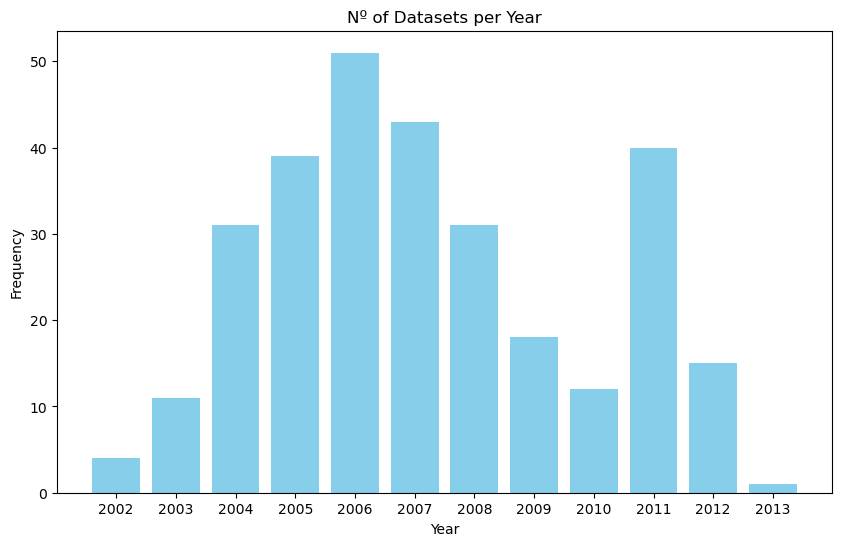

In [ ]:
import matplotlib.pyplot as plt, os
from collections import Counter

# Count the frequency of each year
year_counts = Counter(dates_year)

# Create lists for the bar plot
years_sorted = sorted(year_counts.keys())
frequencies = [year_counts[year] for year in years_sorted]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(years_sorted, frequencies, color="skyblue")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Nº of Datasets per Year")
plt.xticks(years_sorted)

plt.savefig(
    os.path.join("../results/figures/iLINCS/numbers", "n_datasets_per_year.png"),
    dpi=300,
    bbox_inches="tight",
)

# Examples

Here we will showcase specific examples of datasets and signatures

## Examples: Inexact Dataset Annotation

In [ ]:
"""
Examples: Inexact Dataset Annotation

Here we will showcase examples of signatures that are annotated with a 
given MeSH term but which are inexact


Structure:

    1. Imports, Variables, Functions
    2. Load Data
    3. Retrieve MeSH symbols
    4. Retrieve Signatures
    
"""

# 1. Imports, Variables, Functions
# imports
import pandas as pd, numpy as np, statistics, requests, json, logging
from Bio import Entrez
import xml.etree.ElementTree as ET
import time

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
base_url = "http://www.ilincs.org/api"
Entrez.email = "dylandaltonsub@gmail.com"
base_url = "http://www.ilincs.org/api"
doi_data_path = "../data/DiseaseOntology/doid.obo"
mesh_file_path = "../data/MeSH/desc2023.xml"

d_signature_2_mesh = dict()
d_mesh_symbol_2_term = dict()

failed_translation_all = list()
d_dataset_2_mesh = dict()


# functions
def get_disease_signatures():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return df_data


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Load Data
# load signatures
df_signatures = get_disease_signatures()

# load datasets
datasets = df_signatures["datasetid"].unique()


# 3. Retrieve MeSH symbols
# load MeSH terms from datasets
# generated in SQL notebook
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

# load mesh terms
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)


# we can retrieve from pmid the mesh terms but we need to map these to symbols


for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbol[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbol"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms


# 4. Retrieve Signatures

/tmp/ipykernel_56783/681096155.py:57: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(path_data)
2023-12-30 17:44:24,294 - INFO - Data loaded successfully.


In [ ]:
for k in d_dataset_2_mesh.keys():
    if any("colitis" in t.lower() for t in d_dataset_2_mesh[k]["terms"]):
        print(k, d_dataset_2_mesh[k]["terms"])

gdsGDS1330 ['Adolescent', 'Adult', 'Aged', 'Aged, 80 and over', 'Antigens, CD', 'Cell Adhesion Molecules', 'Colitis, Ulcerative', 'Crohn Disease', 'Deubiquitinating Enzyme CYLD', 'Female', 'Gene Expression Profiling', 'Gene Expression Regulation', 'Genome, Human', 'Humans', 'Immunohistochemistry', 'Inflammatory Bowel Diseases', 'Intestinal Mucosa', 'Male', 'Middle Aged', 'Oligonucleotide Array Sequence Analysis', 'Protein Kinase C', 'Protein Kinase C beta', 'Tumor Suppressor Proteins']
gdsGDS1615 ['Adult', 'Case-Control Studies', 'Colitis, Ulcerative', 'Crohn Disease', 'Gene Expression Profiling', 'Humans', 'Leukocytes, Mononuclear', 'Male', 'Molecular Diagnostic Techniques', 'Reverse Transcriptase Polymerase Chain Reaction']
gdsGDS559 ['Adult', 'Aquaporins', 'Biopsy', 'Case-Control Studies', 'Colitis, Ulcerative', 'Colon', 'Disease Susceptibility', 'Female', 'Gene Expression Regulation', 'Humans', 'Ileum', 'Intestinal Mucosa', 'Male', 'Middle Aged', 'Oligonucleotide Array Sequence Ana

In [ ]:
# Set the maximum number of columns to display
pd.set_option("display.max_columns", None)

# Your code here
df_signatures[df_signatures["datasetid"] == "gdsGDS2642"]

,antibodytarget,cellline,tissue,cid,compound,concentration,concordancetable,datasetid,factor,level1,level2,libraryid,lincspertid,nCtrSamples,nTrtSamples,peaktype,platform,signatureid,lincsSigID,organism,clueIoCompound,integratedMoas,GeneTargets,time,treatment,perturbagenID,stitchID,pubChemID,is_exemplar,pert_type
27455,NaN,NaN,NaN,cID_6045,NaN,NaN,concordanceLib1,gdsGDS2642,disease.state,Crohns_disease,normal,LIB_1,NaN,NaN,NaN,NaN,gdsGPL91,GDS_6045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27456,NaN,NaN,NaN,cID_6046,NaN,NaN,concordanceLib1,gdsGDS2642,disease.state,Crohns_disease,ulcerative_colitis,LIB_1,NaN,NaN,NaN,NaN,gdsGPL91,GDS_6046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27457,NaN,NaN,NaN,cID_6047,NaN,NaN,concordanceLib1,gdsGDS2642,disease.state,normal,ulcerative_colitis,LIB_1,NaN,NaN,NaN,NaN,gdsGPL91,GDS_6047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27458,NaN,NaN,NaN,cID_6048,NaN,NaN,concordanceLib1,gdsGDS2642,specimen,affected,control,LIB_1,NaN,NaN,NaN,NaN,gdsGPL91,GDS_6048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27459,NaN,NaN,NaN,cID_6049,NaN,NaN,concordanceLib1,gdsGDS2642,specimen,affected,unaffected,LIB_1,NaN,NaN,NaN,NaN,gdsGPL91,GDS_6049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27461,NaN,NaN,NaN,cID_6050,NaN,NaN,concordanceLib1,gdsGDS2642,specimen,control,unaffected,LIB_1,NaN,NaN,NaN,NaN,gdsGPL91,GDS_6050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
